In [1]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

In [2]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
from IPython.display import SVG, display, clear_output
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [3]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


In [4]:
data.loc[data['dataset'] == 'test']['class'].value_counts()

1     1516
2     1190
6      824
3      567
7      462
9      184
4       91
8       82
5       68
10      23
Name: class, dtype: int64

## Select one set of settings to test
(use the test_similiarity.py script to do the full set of experiments)

In [10]:
class_ = 3
similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity
similarity_label = 'Tanimoto'
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=True)
getfp_label = 'Morgan2Feat'
dataset = 'test'
label = '{}_class{}_fp{}_sim{}'.format(
    dataset,
    class_,
    getfp_label,
    similarity_label,
)

### Only get new FPs if necessary - is a little slow

In [6]:
try:
    if prev_FP != getfp_label:
        raise NameError
except NameError:
    all_fps = []
    for smi in tqdm(data['prod_smiles']):
        all_fps.append(getfp(smi))
    data['prod_fp'] = all_fps
    prev_FP = getfp_label

100%|██████████| 50016/50016 [00:41<00:00, 1196.79it/s]


### Get the training data subset of the full data

In [11]:
if class_ != 'all':
    datasub = data.loc[data['class'] == class_].loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['class'] == class_].loc[data['dataset'] == dataset]
else:
    datasub = data.loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['dataset'] == dataset]
fps = list(datasub['prod_fp'])
print('Size of knowledge base: {}'.format(len(fps)))

Size of knowledge base: 4529


## Go through full validation/test data, define the function for processing

In [12]:
jx_cache = {}
draw = False
debug = False

def do_one(ix, draw=draw, debug=debug, max_prec=100, nopause=False):
    
    rec_for_printing = ''
    
    ex = Chem.MolFromSmiles(datasub_val['prod_smiles'][ix])
    rct = rdchiralReactants(datasub_val['prod_smiles'][ix])
    if draw: 
        print('Mol {}'.format(ix))
    if debug:
        rec_for_printing += datasub_val['prod_smiles'][ix] + '\n'
        rec_for_printing += 'True reaction:'
        rec_for_printing += datasub_val['rxn_smiles'][ix] + '\n'
    fp = datasub_val['prod_fp'][ix]
    
    sims = similarity_metric(fp, [fp_ for fp_ in datasub['prod_fp']])
    js = np.argsort(sims)[::-1]

    if draw: display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
    
    prec_goal = Chem.MolFromSmiles(datasub_val['rxn_smiles'][ix].split('>')[0])
    [a.ClearProp('molAtomMapNumber') for a in prec_goal.GetAtoms()]
    prec_goal = Chem.MolToSmiles(prec_goal, True)
    
    # Sometimes stereochem takes another canonicalization...
    prec_goal = Chem.MolToSmiles(Chem.MolFromSmiles(prec_goal), True)
    if debug:
        rec_for_printing += 'prec_goal: {}\n'.format(prec_goal)
    # Get probability of precursors
    probs = {}
    
    for ji, j in enumerate(js[:max_prec]):
        jx = datasub.index[j]
        
        if draw:
            print('\n\n' + '-'*50 + '\n')
            print('RANK {} PRECEDENT'.format(ji+1))
            print('PRODUCT MATCH SCORE: {}'.format(sims[j]))
            display(ReactionStringToImage(datasub['rxn_smiles'][jx]))
        if debug:
            rec_for_printing += '\nReaction precedent {}, prod similarity {}\n'.format(
                ji+1, sims[j])
            rec_for_printing += '-> rxn_smiles {}\n'.format(datasub['rxn_smiles'][jx])
        if jx in jx_cache:
            (rxn, template, rcts_ref_fp) = jx_cache[jx]
        else:
            template = '(' + process_an_example(datasub['rxn_smiles'][jx], super_general=True).replace('>>', ')>>')
            rcts_ref_fp = getfp(datasub['rxn_smiles'][jx].split('>')[0])
            rxn = rdchiralReaction(template)
            jx_cache[jx] = (rxn, template, rcts_ref_fp)
        if debug:
            rec_for_printing += '-> template: {}\n'.format(template)
        if draw:
            print('-> template: {}'.format(template))
            
        try:
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        except Exception as e:
            print(e)
            outcomes = []

        if not outcomes and draw:
            print('No precursors could be generated!')
            
        for precursors in outcomes:
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            if debug:
                rec_for_printing += 'prec sim {} smiles {}\n'.format(precursors_sim, precursors)
            if draw:
                print('Precursor similarity {}, overall {}, smiles {}'.format(
                    precursors_sim, precursors_sim*sims[j], precursors))
                display(MolToImage(Chem.MolFromSmiles(precursors)))
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    
    testlimit = 50
    mols = []
    legends = []

    found_rank = 9999
    for r, (prec, prob) in enumerate(sorted(probs.iteritems(), key=lambda x:x[1], reverse=True)[:testlimit]):
        mols.append(Chem.MolFromSmiles(prec))
        if prec == prec_goal:
            found_rank = r + 1
            legends.append('[TRUE] {}'.format(prob))
        else:
            legends.append('{}'.format(prob))
            pass
    if found_rank == 9999 and debug:
        print(datasub_val['rxn_smiles'][ix])
        display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
        print(prec_goal)
        draw = True
    
    if draw: 
        img=MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9])
        display(img)
        for mol in mols[:9]:
            print(Chem.MolToSmiles(mol, True))
    if debug:
        print(rec_for_printing)
    if (draw or debug) and not nopause:
        raw_input('pause')
        clear_output()
        
    return found_rank

## More examples from each class

45105
3
Mol 45105


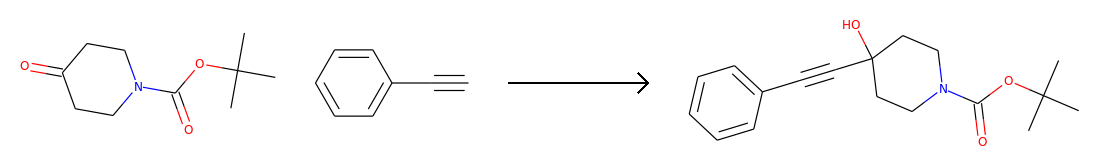



--------------------------------------------------

RANK 1 PRECEDENT
PRODUCT MATCH SCORE: 0.760563380282


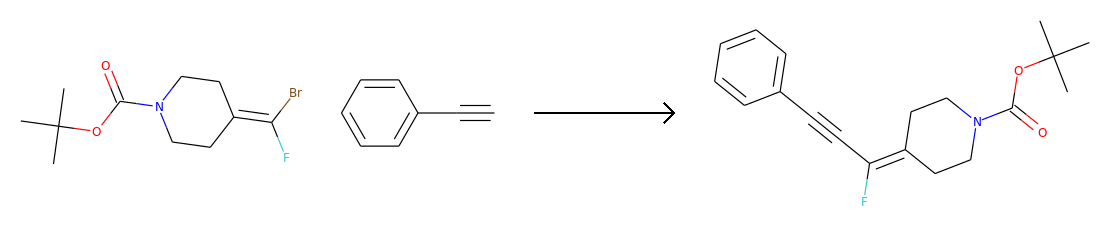

-> template: ([C;H0;+0:1]-[C;H0;+0:2])>>Br-[C;H0;+0:2].[CH;+0:1]
Precursor similarity 0.72972972973, overall 0.555005709935, smiles BrC#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)CC1


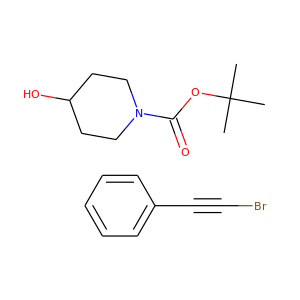

Precursor similarity 0.788732394366, overall 0.599880975997, smiles C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(Br)CC1


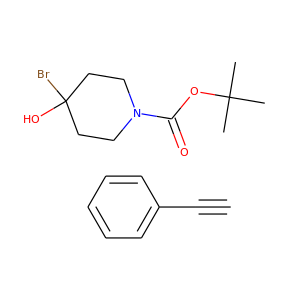



--------------------------------------------------

RANK 2 PRECEDENT
PRODUCT MATCH SCORE: 0.760563380282


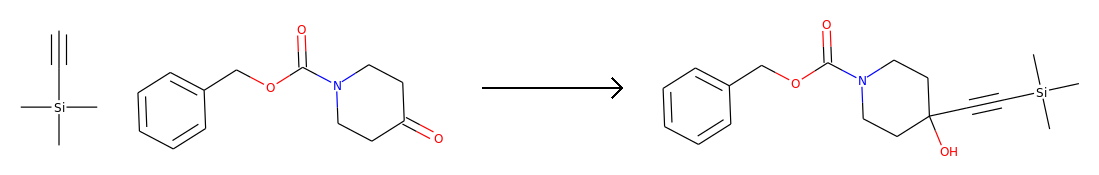

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH;+0:1]
Precursor similarity 0.794117647059, overall 0.603976801988, smiles C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(=O)CC1


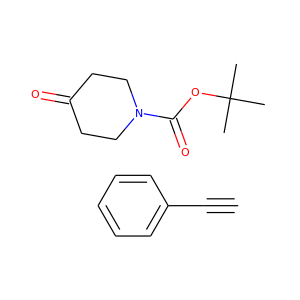



--------------------------------------------------

RANK 3 PRECEDENT
PRODUCT MATCH SCORE: 0.733333333333


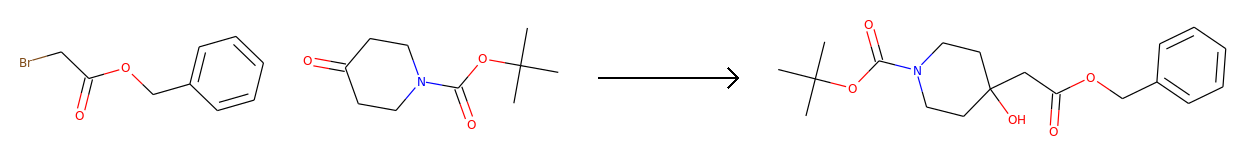

-> template: ([CH2;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>Br-[CH2;+0:1].[C;H0;+0:2]=[O;H0;+0:3]
Precursor similarity 0.696202531646, overall 0.510548523207, smiles CC(C)(C)OC(=O)N(CCBr)CCC(=O)C#Cc1ccccc1


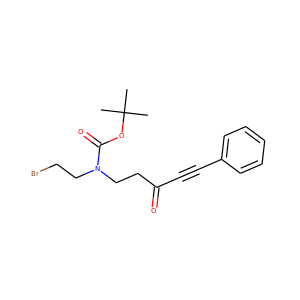



--------------------------------------------------

RANK 4 PRECEDENT
PRODUCT MATCH SCORE: 0.710526315789


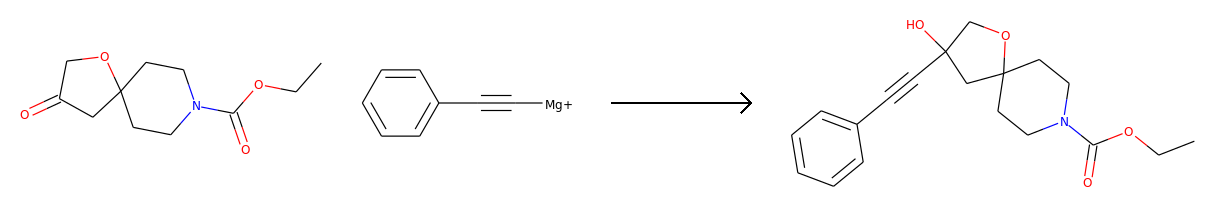

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:1]-[Mg+].[C;H0;+0:2]=[O;H0;+0:3]
Precursor similarity 0.717948717949, overall 0.51012145749, smiles CC(C)(C)OC(=O)N1CCC(=O)CC1.[Mg+]C#Cc1ccccc1


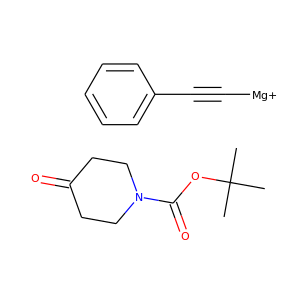



--------------------------------------------------

RANK 5 PRECEDENT
PRODUCT MATCH SCORE: 0.685714285714


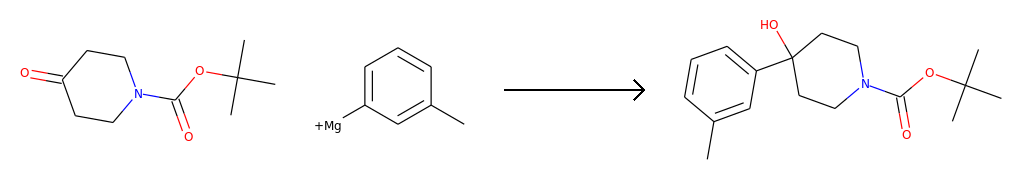

-> template: ([OH;+0:1]-[C;H0;+0:2]-[c;H0;+0:3])>>[C;H0;+0:2]=[O;H0;+0:1].[Mg+]-[c;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 6 PRECEDENT
PRODUCT MATCH SCORE: 0.671428571429


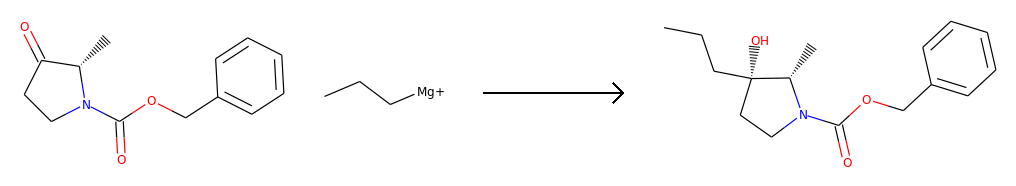

-> template: ([CH2;+0:1]-[C;@;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.69014084507, overall 0.46338028169, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


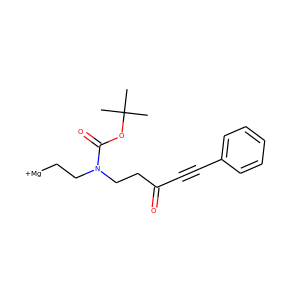



--------------------------------------------------

RANK 7 PRECEDENT
PRODUCT MATCH SCORE: 0.647887323944


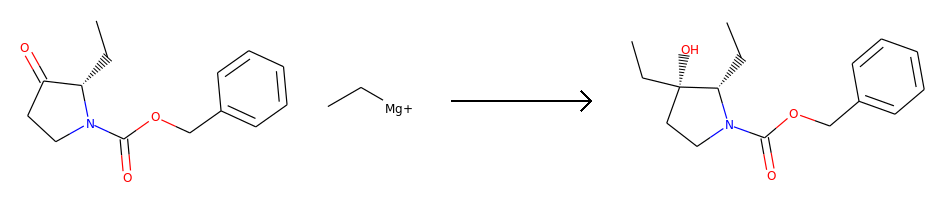

-> template: ([CH2;+0:1]-[C;@;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.666666666667, overall 0.431924882629, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


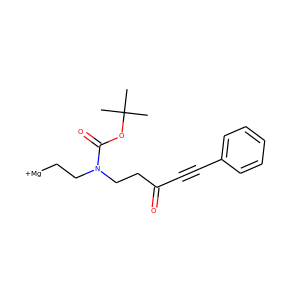



--------------------------------------------------

RANK 8 PRECEDENT
PRODUCT MATCH SCORE: 0.630136986301


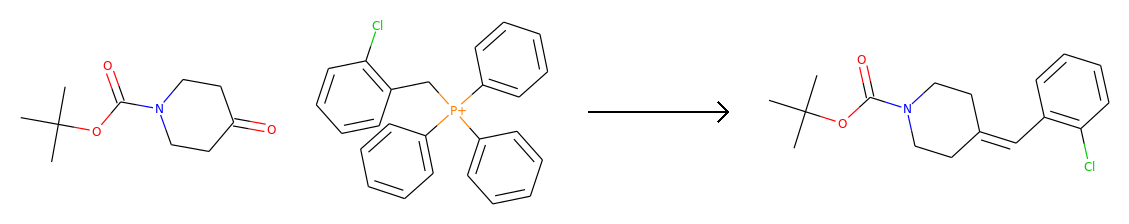

-> template: ([C;H0;+0:1]=[CH;+0:2])>>O=[C;H0;+0:1].[CH2;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 9 PRECEDENT
PRODUCT MATCH SCORE: 0.619047619048


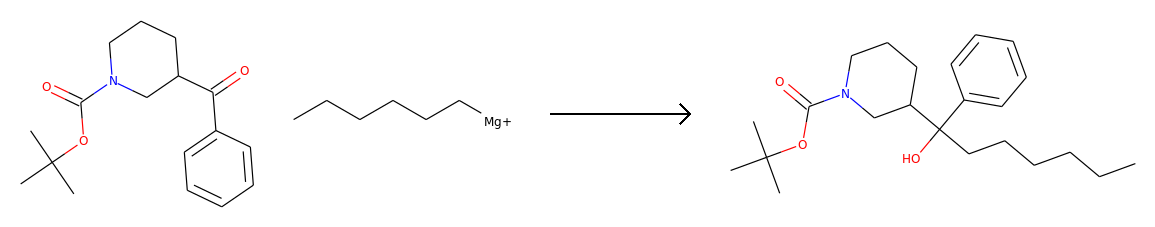

-> template: ([CH2;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.647058823529, overall 0.40056022409, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


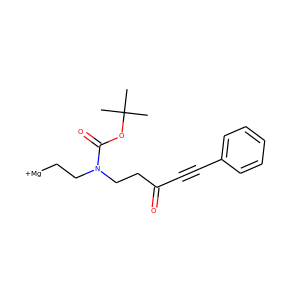



--------------------------------------------------

RANK 10 PRECEDENT
PRODUCT MATCH SCORE: 0.613333333333


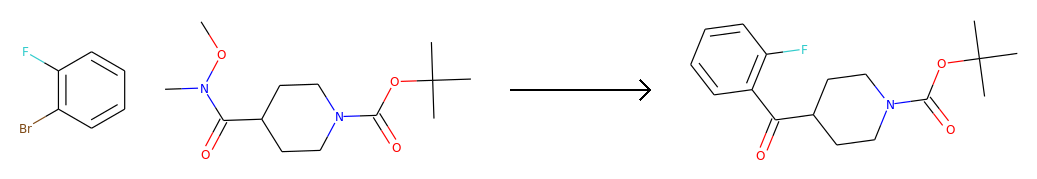

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-O-N(-C)-[C;H0;+0:1]
Precursor similarity 0.611111111111, overall 0.374814814815, smiles Brc1ccccc1.CON(C)C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


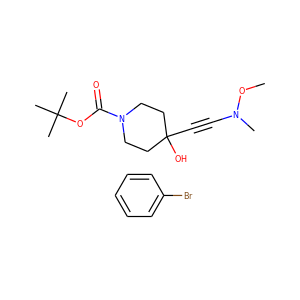



--------------------------------------------------

RANK 11 PRECEDENT
PRODUCT MATCH SCORE: 0.602564102564


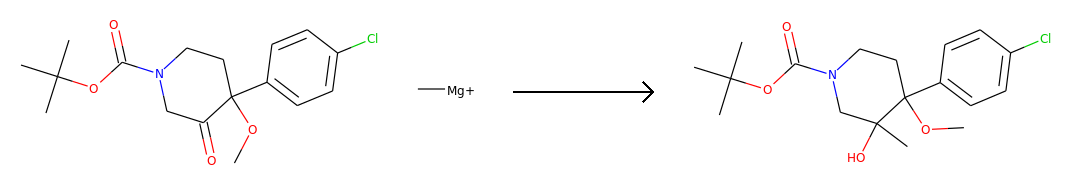

-> template: ([CH3;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH3;+0:1]-[Mg+]
No precursors could be generated!


--------------------------------------------------

RANK 12 PRECEDENT
PRODUCT MATCH SCORE: 0.6


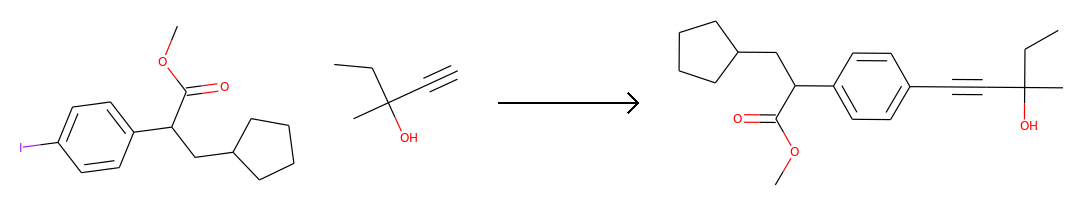

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.604938271605, overall 0.362962962963, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


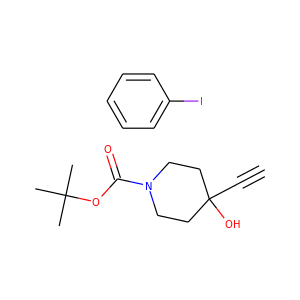



--------------------------------------------------

RANK 13 PRECEDENT
PRODUCT MATCH SCORE: 0.589743589744


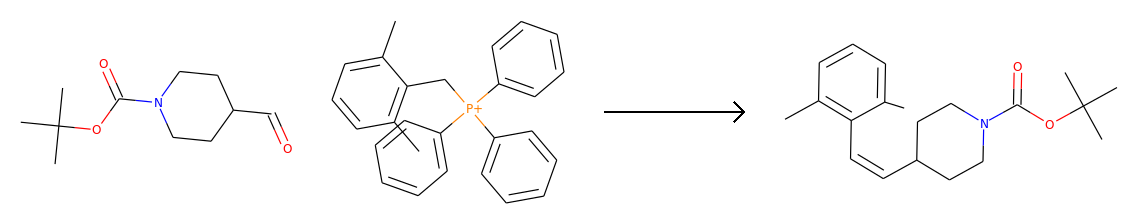

-> template: ([CH;+0:1]=[CH;+0:2])>>O=[CH;+0:2].[CH2;+0:1]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 14 PRECEDENT
PRODUCT MATCH SCORE: 0.589743589744


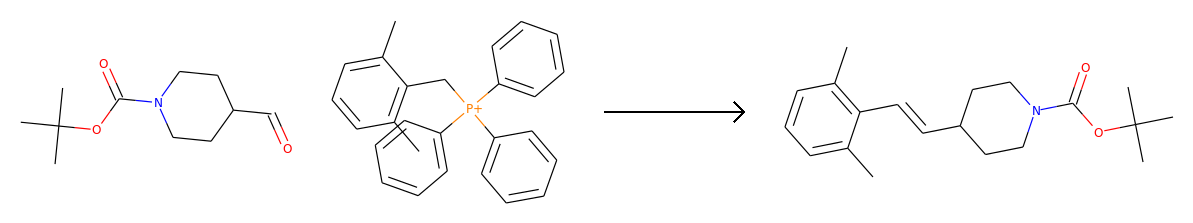

-> template: ([CH;+0:1]=[CH;+0:2])>>O=[CH;+0:2].[CH2;+0:1]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 15 PRECEDENT
PRODUCT MATCH SCORE: 0.58904109589


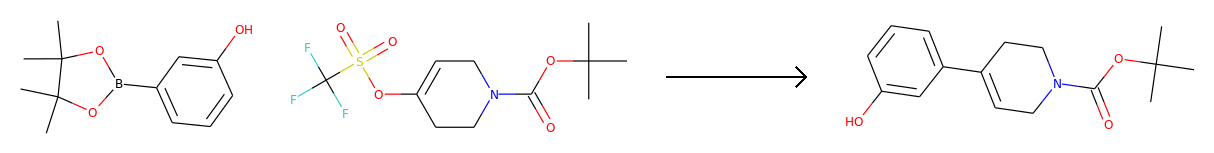

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>C-C1(-C)-O-B(-[c;H0;+0:2])-O-C-1(-C)-C.F-C(-F)(-F)-S(=O)(=O)-O-[C;H0;+0:1]
Precursor similarity 0.739130434783, overall 0.43537820131, smiles CC(C)(C)OC(=O)N1CCC(O)(C#COS(=O)(=O)C(F)(F)F)CC1.CC1(C)OB(c2ccccc2)OC1(C)C


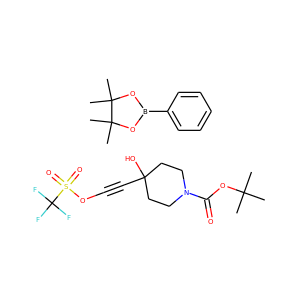



--------------------------------------------------

RANK 16 PRECEDENT
PRODUCT MATCH SCORE: 0.5875


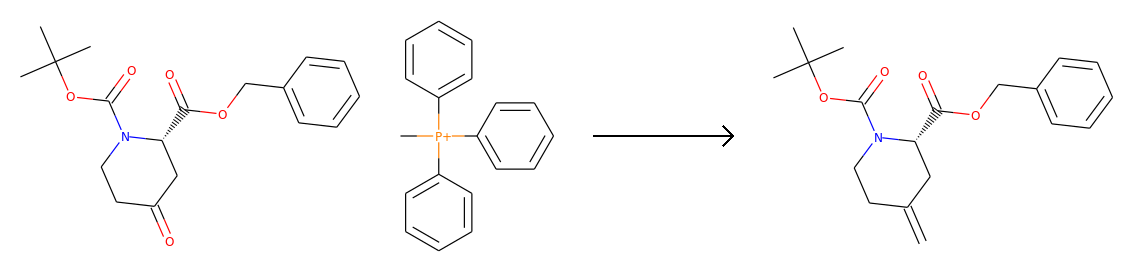

-> template: ([C;H0;+0:1]=[CH2;+0:2])>>O=[C;H0;+0:1].[CH3;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 17 PRECEDENT
PRODUCT MATCH SCORE: 0.586666666667


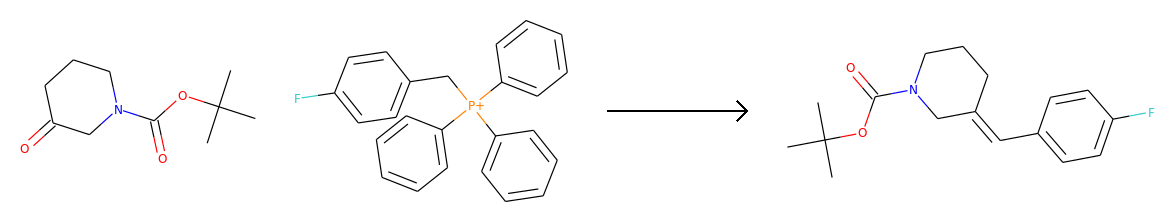

-> template: ([C;H0;+0:1]=[CH;+0:2])>>O=[C;H0;+0:1].[CH2;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 18 PRECEDENT
PRODUCT MATCH SCORE: 0.582278481013


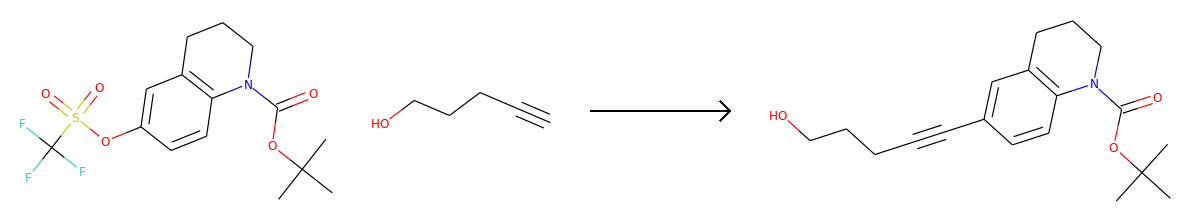

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>F-C(-F)(-F)-S(=O)(=O)-O-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.642857142857, overall 0.374321880651, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.O=S(=O)(Oc1ccccc1)C(F)(F)F


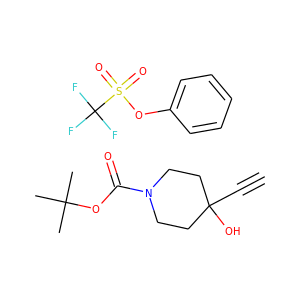



--------------------------------------------------

RANK 19 PRECEDENT
PRODUCT MATCH SCORE: 0.569620253165


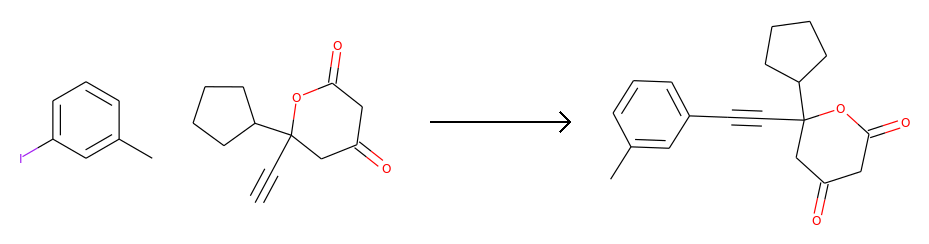

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.555555555556, overall 0.316455696203, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


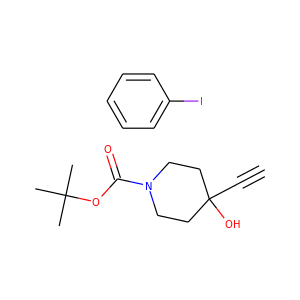



--------------------------------------------------

RANK 20 PRECEDENT
PRODUCT MATCH SCORE: 0.565789473684


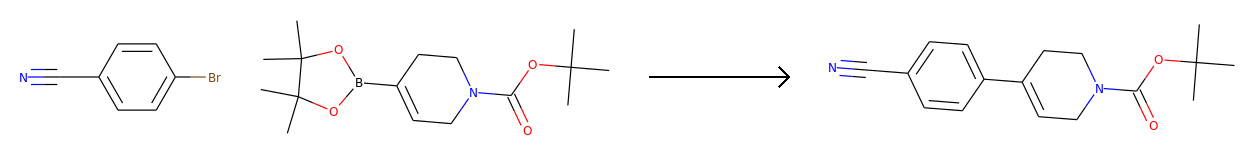

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-C1(-C)-O-B(-[C;H0;+0:1])-O-C-1(-C)-C
Precursor similarity 0.673267326733, overall 0.380927566441, smiles Brc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1


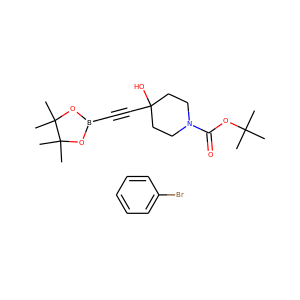



--------------------------------------------------

RANK 21 PRECEDENT
PRODUCT MATCH SCORE: 0.560975609756


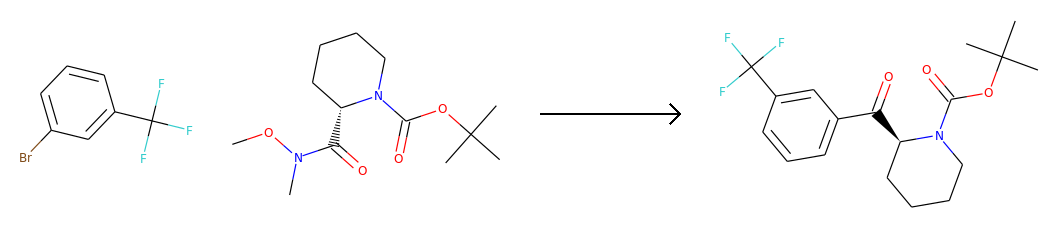

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-O-N(-C)-[C;H0;+0:1]
Precursor similarity 0.535353535354, overall 0.30032027593, smiles Brc1ccccc1.CON(C)C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


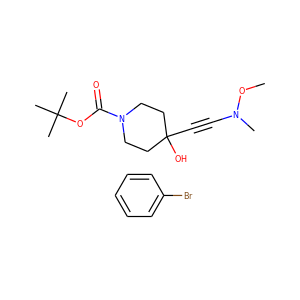



--------------------------------------------------

RANK 22 PRECEDENT
PRODUCT MATCH SCORE: 0.560975609756


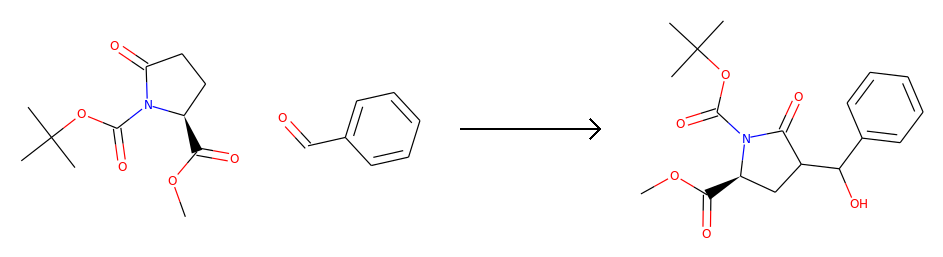

-> template: ([CH;+0:1]-[CH;+0:2]-[OH;+0:3])>>[CH2;+0:1].[CH;+0:2]=[O;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 23 PRECEDENT
PRODUCT MATCH SCORE: 0.559523809524


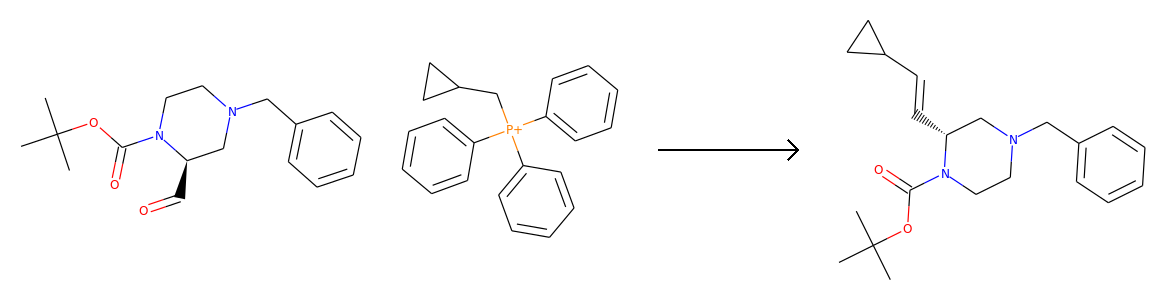

-> template: ([CH;+0:1]=[CH;+0:2])>>O=[CH;+0:1].[CH2;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 24 PRECEDENT
PRODUCT MATCH SCORE: 0.551282051282


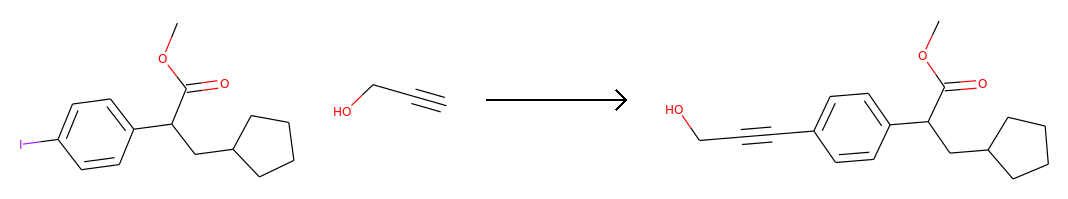

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.564102564103, overall 0.310979618672, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


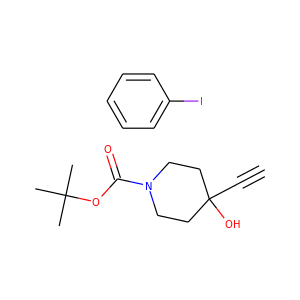



--------------------------------------------------

RANK 25 PRECEDENT
PRODUCT MATCH SCORE: 0.549450549451


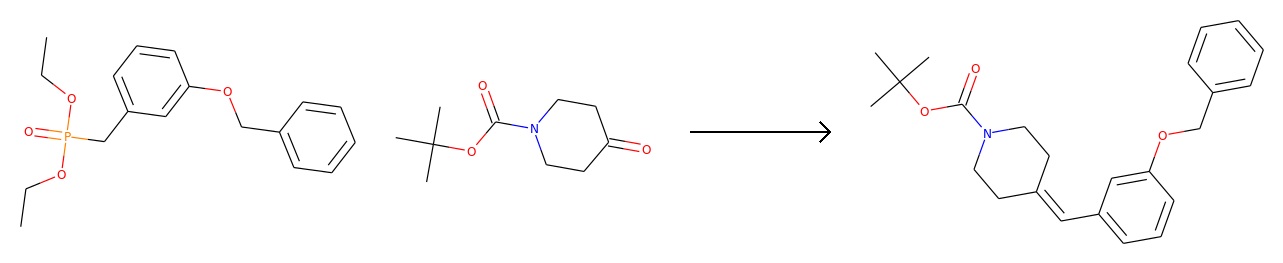

-> template: ([C;H0;+0:1]=[CH;+0:2])>>C-C-O-P(=O)(-[CH2;+0:2])-O-C-C.O=[C;H0;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 26 PRECEDENT
PRODUCT MATCH SCORE: 0.54347826087


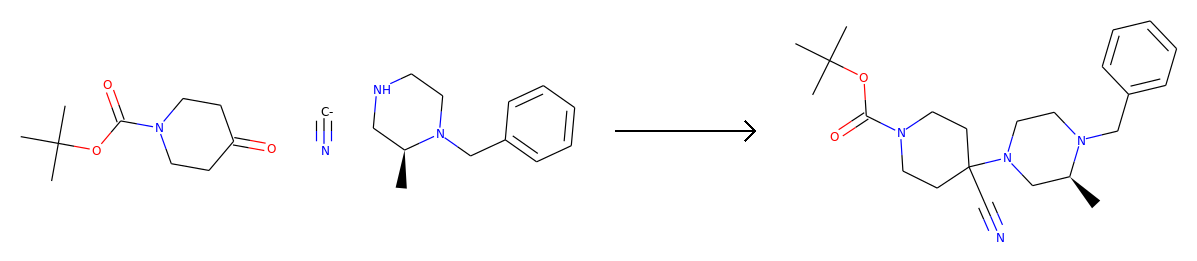

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[N;H0;+0:3])>>O=[C;H0;+0:2].[C-;H0:1].[NH;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 27 PRECEDENT
PRODUCT MATCH SCORE: 0.539682539683


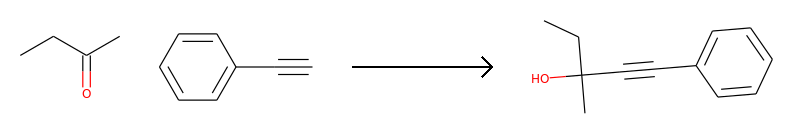

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH;+0:1]
Precursor similarity 0.540983606557, overall 0.291959406714, smiles C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(=O)CC1


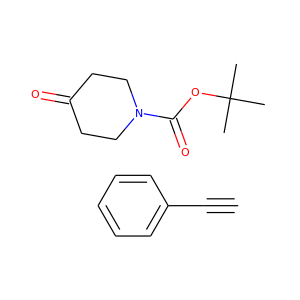



--------------------------------------------------

RANK 28 PRECEDENT
PRODUCT MATCH SCORE: 0.53488372093


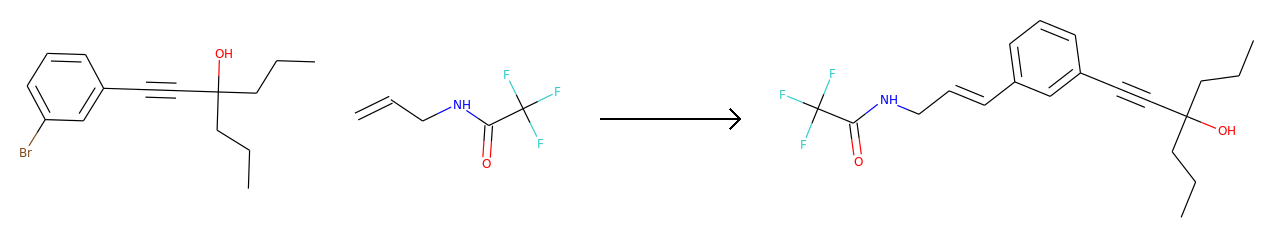

-> template: ([CH;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH2;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 29 PRECEDENT
PRODUCT MATCH SCORE: 0.53488372093


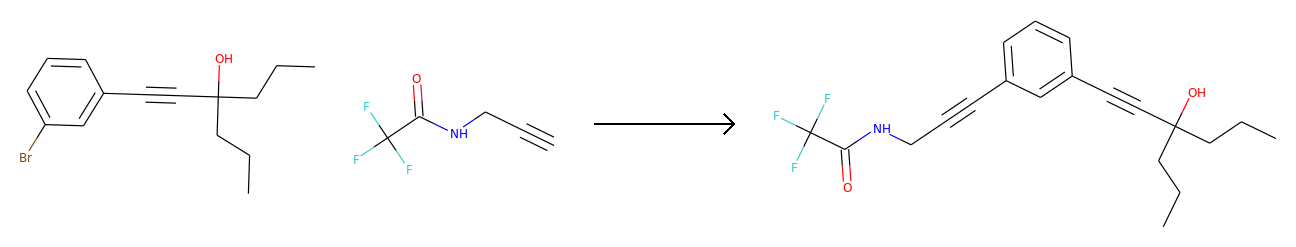

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.505617977528, overall 0.270446825189, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


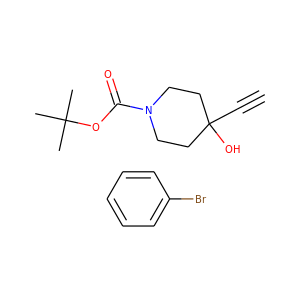



--------------------------------------------------

RANK 30 PRECEDENT
PRODUCT MATCH SCORE: 0.534246575342


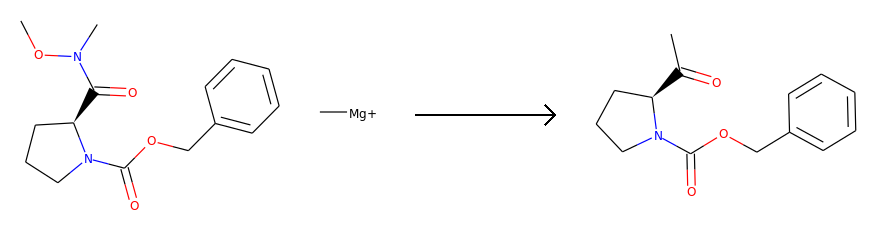

-> template: ([C;H0;+0:1]-[CH3;+0:2])>>C-O-N(-C)-[C;H0;+0:1].[CH3;+0:2]-[Mg+]
Precursor similarity 0.540229885057, overall 0.28861596599, smiles CON(C)C(C)(C)OC(=O)N1CCC(O)(C#Cc2ccccc2)CC1.C[Mg+]


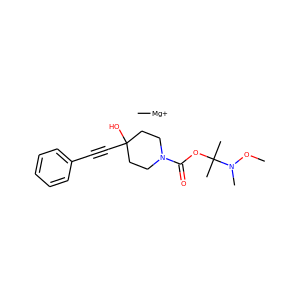



--------------------------------------------------

RANK 31 PRECEDENT
PRODUCT MATCH SCORE: 0.534090909091


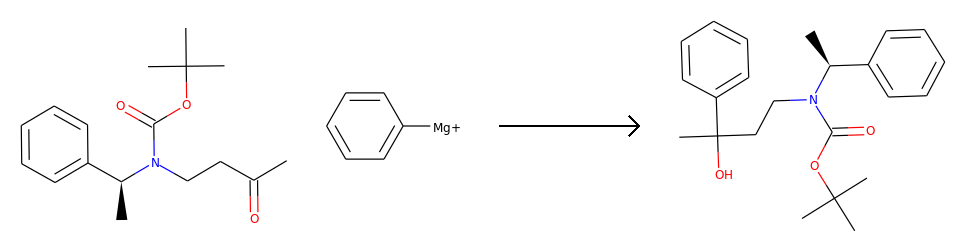

-> template: ([OH;+0:1]-[C;H0;+0:2]-[c;H0;+0:3])>>[C;H0;+0:2]=[O;H0;+0:1].[Mg+]-[c;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 32 PRECEDENT
PRODUCT MATCH SCORE: 0.53164556962


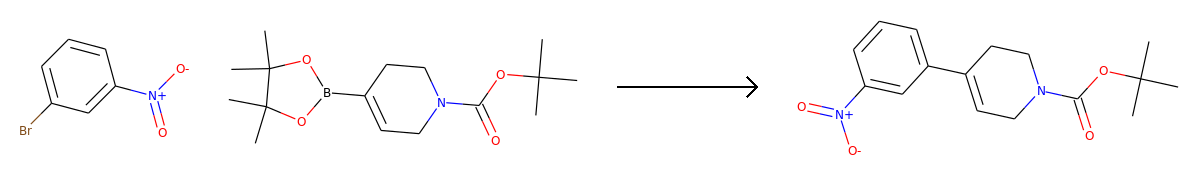

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-C1(-C)-O-B(-[C;H0;+0:1])-O-C-1(-C)-C
Precursor similarity 0.644230769231, overall 0.342502434275, smiles Brc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1


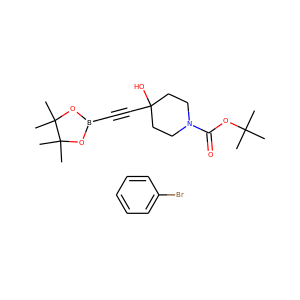



--------------------------------------------------

RANK 33 PRECEDENT
PRODUCT MATCH SCORE: 0.53164556962


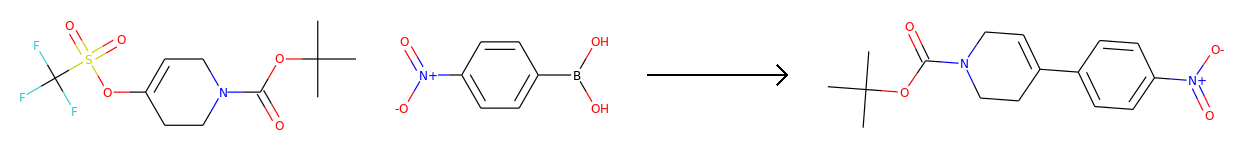

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>F-C(-F)(-F)-S(=O)(=O)-O-[C;H0;+0:1].O-B(-O)-[c;H0;+0:2]
Precursor similarity 0.647619047619, overall 0.344303797468, smiles CC(C)(C)OC(=O)N1CCC(O)(C#COS(=O)(=O)C(F)(F)F)CC1.OB(O)c1ccccc1


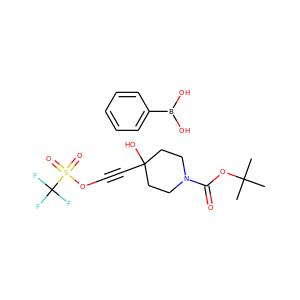



--------------------------------------------------

RANK 34 PRECEDENT
PRODUCT MATCH SCORE: 0.527472527473


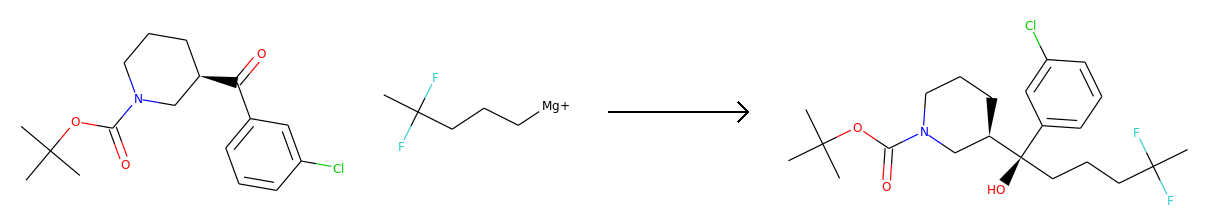

-> template: ([CH2;+0:1]-[C;@;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.554347826087, overall 0.292403248925, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


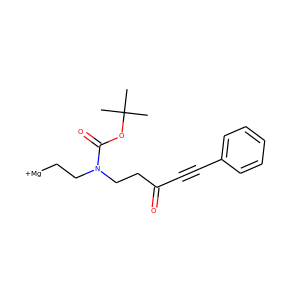



--------------------------------------------------

RANK 35 PRECEDENT
PRODUCT MATCH SCORE: 0.52


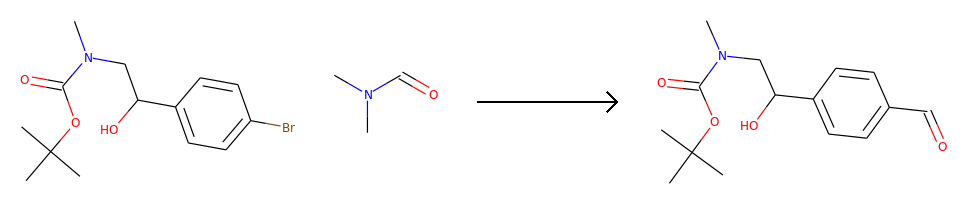

-> template: ([CH;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-N(-C)-[CH;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 36 PRECEDENT
PRODUCT MATCH SCORE: 0.519480519481


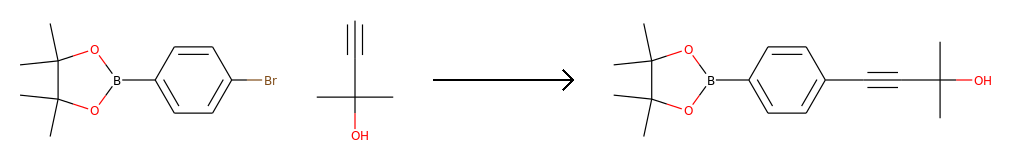

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.532467532468, overall 0.276606510373, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


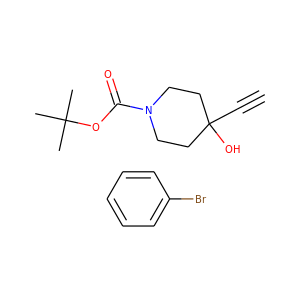



--------------------------------------------------

RANK 37 PRECEDENT
PRODUCT MATCH SCORE: 0.518987341772


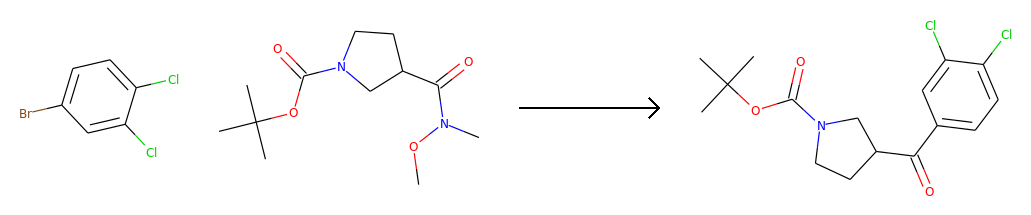

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-O-N(-C)-[C;H0;+0:1]
Precursor similarity 0.548387096774, overall 0.284605961617, smiles Brc1ccccc1.CON(C)C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


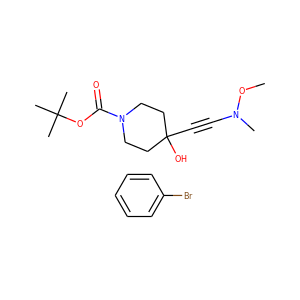



--------------------------------------------------

RANK 38 PRECEDENT
PRODUCT MATCH SCORE: 0.518518518519


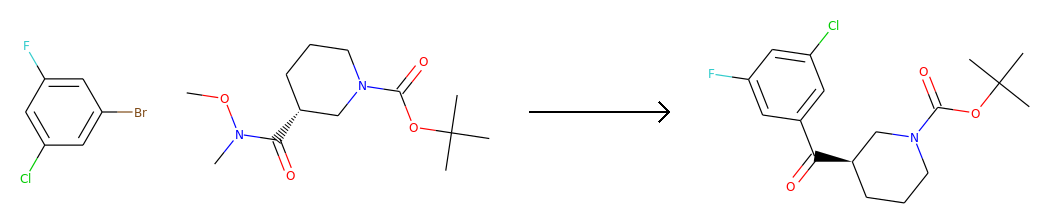

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-O-N(-C)-[C;H0;+0:1]
Precursor similarity 0.53125, overall 0.275462962963, smiles Brc1ccccc1.CON(C)C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


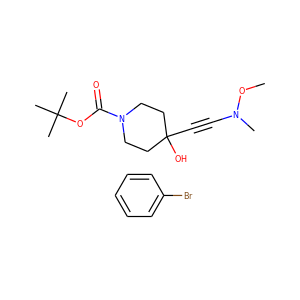



--------------------------------------------------

RANK 39 PRECEDENT
PRODUCT MATCH SCORE: 0.518072289157


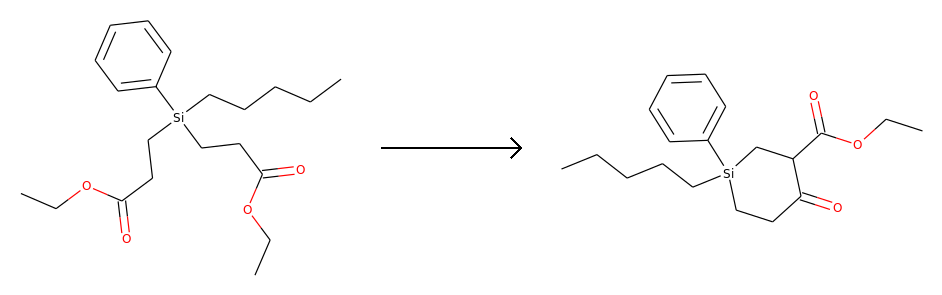

-> template: ([C;H0;+0:1]-[CH;+0:2])>>C-C-O-[C;H0;+0:1].[CH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 40 PRECEDENT
PRODUCT MATCH SCORE: 0.518072289157


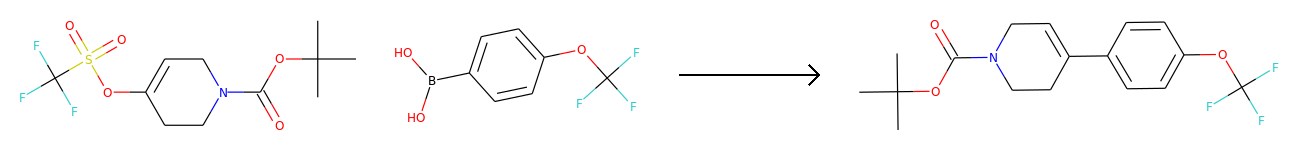

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>F-C(-F)(-F)-S(=O)(=O)-O-[C;H0;+0:1].O-B(-O)-[c;H0;+0:2]
Precursor similarity 0.633027522936, overall 0.327954017906, smiles CC(C)(C)OC(=O)N1CCC(O)(C#COS(=O)(=O)C(F)(F)F)CC1.OB(O)c1ccccc1


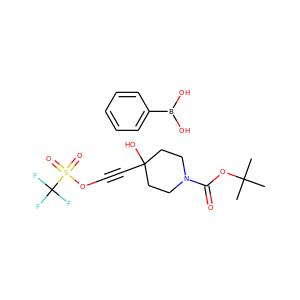



--------------------------------------------------

RANK 41 PRECEDENT
PRODUCT MATCH SCORE: 0.518072289157


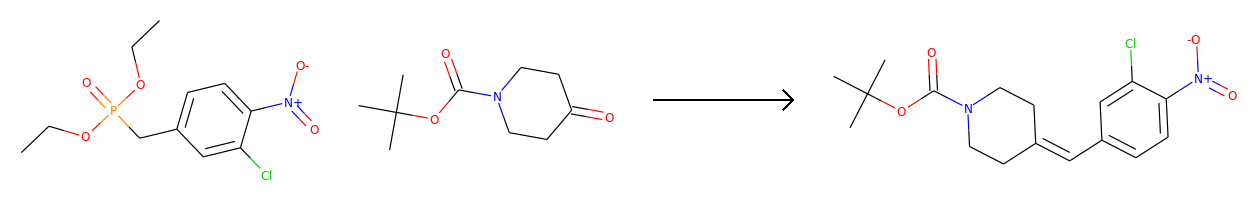

-> template: ([C;H0;+0:1]=[CH;+0:2])>>C-C-O-P(=O)(-[CH2;+0:2])-O-C-C.O=[C;H0;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 42 PRECEDENT
PRODUCT MATCH SCORE: 0.51724137931


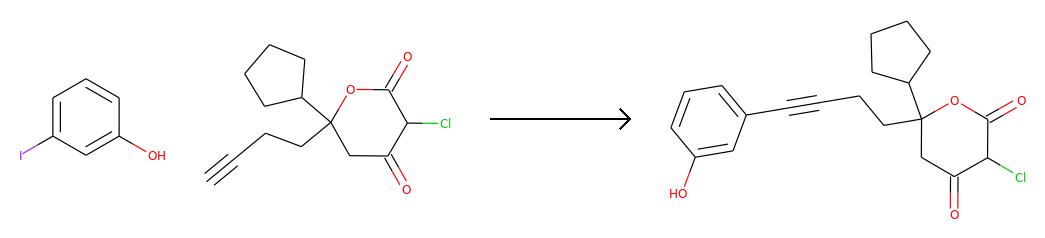

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.522727272727, overall 0.270376175549, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


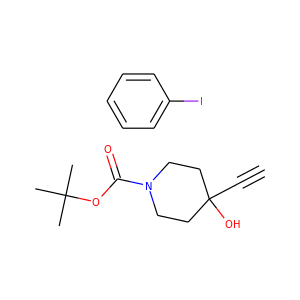



--------------------------------------------------

RANK 43 PRECEDENT
PRODUCT MATCH SCORE: 0.515625


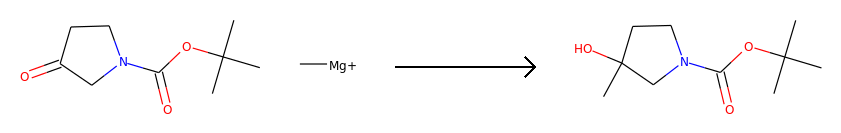

-> template: ([CH3;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH3;+0:1]-[Mg+]
No precursors could be generated!


--------------------------------------------------

RANK 44 PRECEDENT
PRODUCT MATCH SCORE: 0.515625


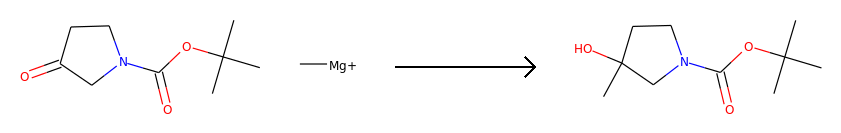

-> template: ([CH3;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH3;+0:1]-[Mg+]
No precursors could be generated!


--------------------------------------------------

RANK 45 PRECEDENT
PRODUCT MATCH SCORE: 0.513513513514


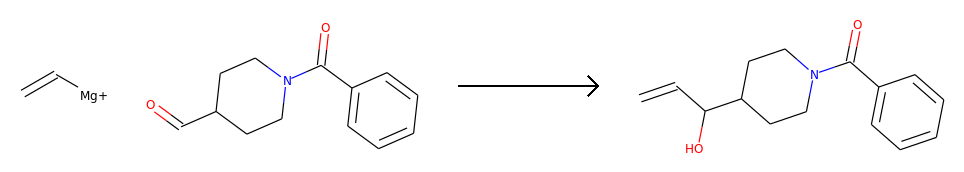

-> template: ([CH;+0:1]-[CH;+0:2]-[OH;+0:3])>>[CH;+0:1]-[Mg+].[CH;+0:2]=[O;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 46 PRECEDENT
PRODUCT MATCH SCORE: 0.512820512821


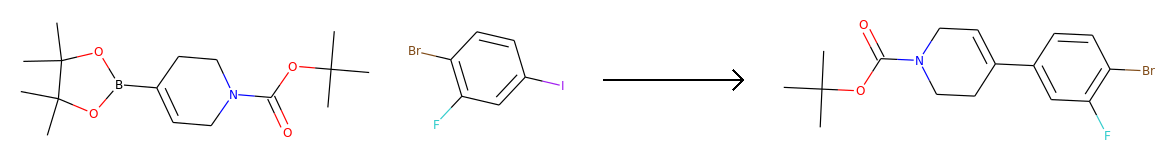

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>C-C1(-C)-O-B(-[C;H0;+0:1])-O-C-1(-C)-C.I-[c;H0;+0:2]
Precursor similarity 0.647058823529, overall 0.331825037707, smiles CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1.Ic1ccccc1


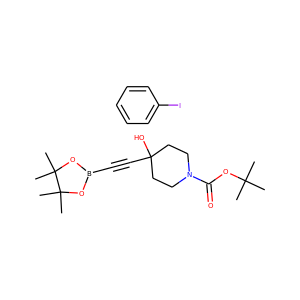



--------------------------------------------------

RANK 47 PRECEDENT
PRODUCT MATCH SCORE: 0.512195121951


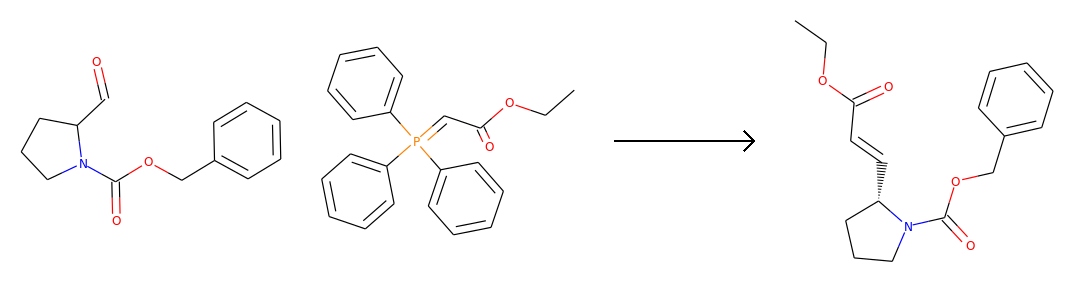

-> template: ([CH;+0:1]=[CH;+0:2]-[CH;@@;+0:3])>>O=[CH;+0:2]-[CH;+0:3].[CH;+0:1]=P(-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 48 PRECEDENT
PRODUCT MATCH SCORE: 0.511627906977


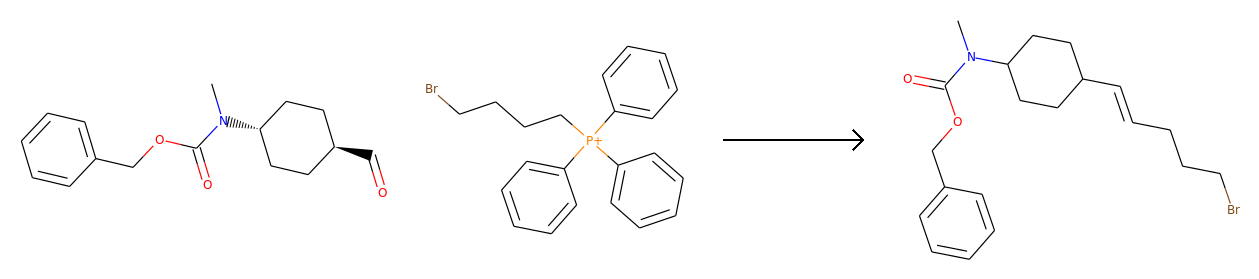

-> template: ([*:1]-[CH;+0:2](-[*:3])-[CH;+0:4]=[CH;+0:5])>>O=[CH;+0:4]-[CH;@@;+0:2](-[*:1])-[*:3].[CH2;+0:5]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 49 PRECEDENT
PRODUCT MATCH SCORE: 0.507042253521


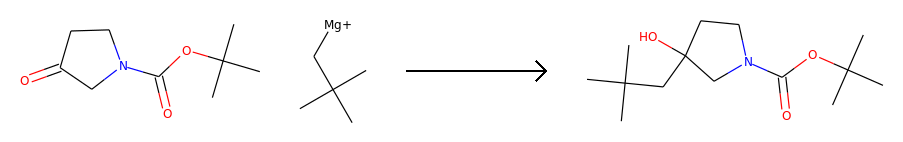

-> template: ([CH2;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.527777777778, overall 0.267605633803, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


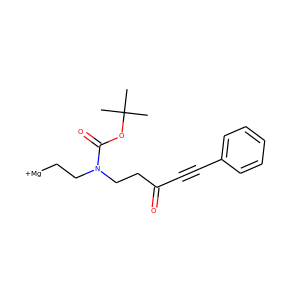



--------------------------------------------------

RANK 50 PRECEDENT
PRODUCT MATCH SCORE: 0.506024096386


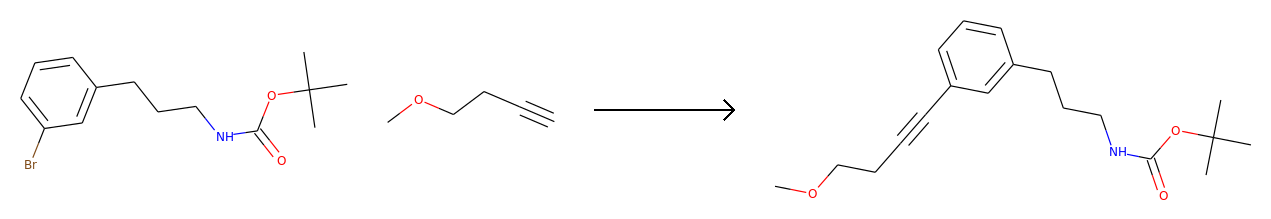

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.494117647059, overall 0.250035435861, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


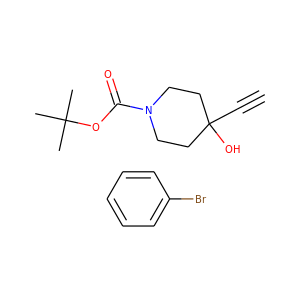



--------------------------------------------------

RANK 51 PRECEDENT
PRODUCT MATCH SCORE: 0.5


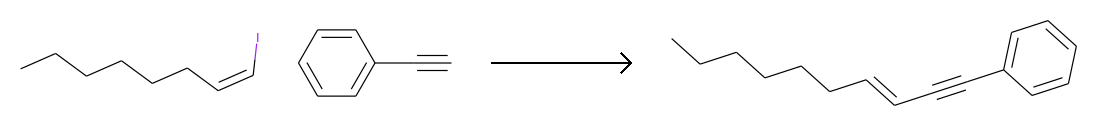

-> template: ([C;H0;+0:1]-[CH;+0:2])>>I-[CH;+0:2].[CH;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 52 PRECEDENT
PRODUCT MATCH SCORE: 0.5


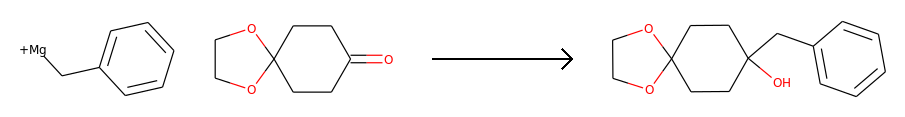

-> template: ([CH2;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.493670886076, overall 0.246835443038, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


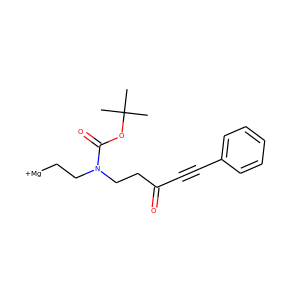



--------------------------------------------------

RANK 53 PRECEDENT
PRODUCT MATCH SCORE: 0.5


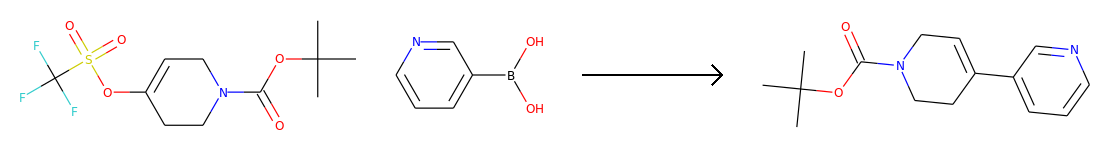

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>F-C(-F)(-F)-S(=O)(=O)-O-[C;H0;+0:1].O-B(-O)-[c;H0;+0:2]
Precursor similarity 0.611650485437, overall 0.305825242718, smiles CC(C)(C)OC(=O)N1CCC(O)(C#COS(=O)(=O)C(F)(F)F)CC1.OB(O)c1ccccc1


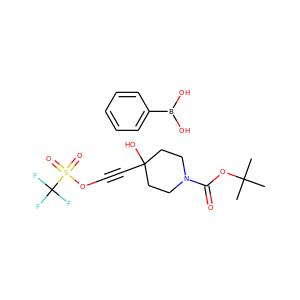



--------------------------------------------------

RANK 54 PRECEDENT
PRODUCT MATCH SCORE: 0.494845360825


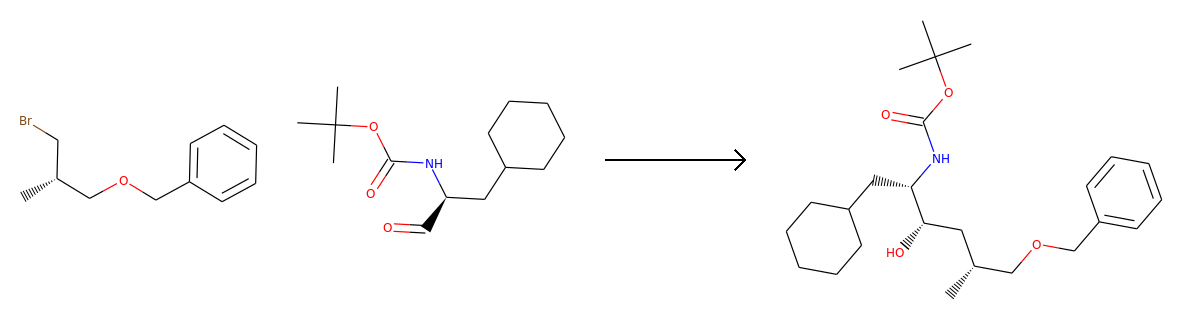

-> template: ([CH2;+0:1]-[CH;@@;+0:2]-[OH;+0:3])>>Br-[CH2;+0:1].[CH;+0:2]=[O;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 55 PRECEDENT
PRODUCT MATCH SCORE: 0.494252873563


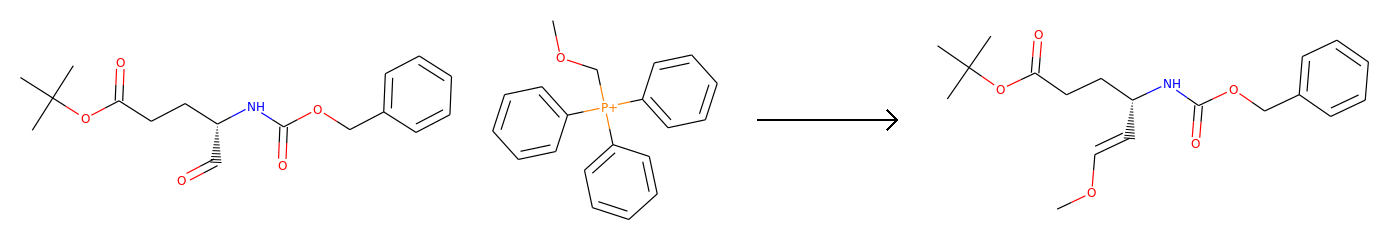

-> template: ([CH;+0:1]=[CH;+0:2])>>O=[CH;+0:1].[CH2;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 56 PRECEDENT
PRODUCT MATCH SCORE: 0.493827160494


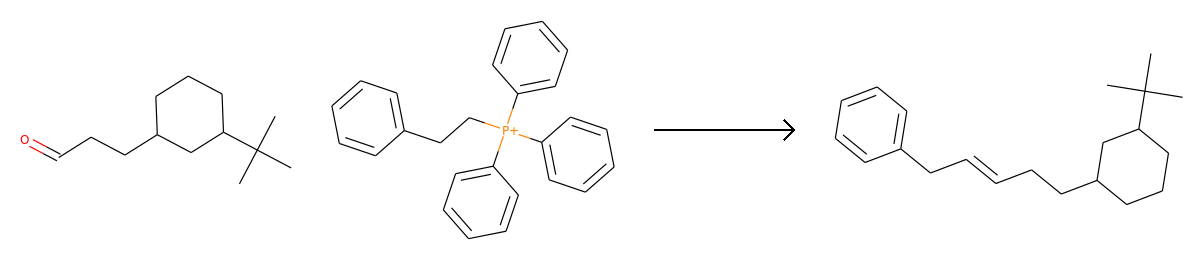

-> template: ([CH;+0:1]=[CH;+0:2])>>O=[CH;+0:2].[CH2;+0:1]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 57 PRECEDENT
PRODUCT MATCH SCORE: 0.493506493506


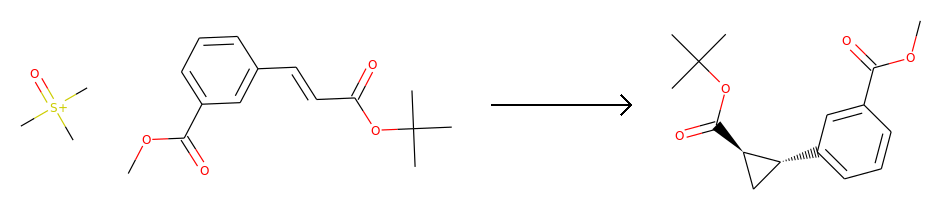

-> template: ([CH2;+0:1]1-[CH;@;+0:2]-[CH;@@;+0:3]-1)>>C-[S+](-C)(=O)-[CH3;+0:1].[CH;+0:3]=[CH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 58 PRECEDENT
PRODUCT MATCH SCORE: 0.492957746479


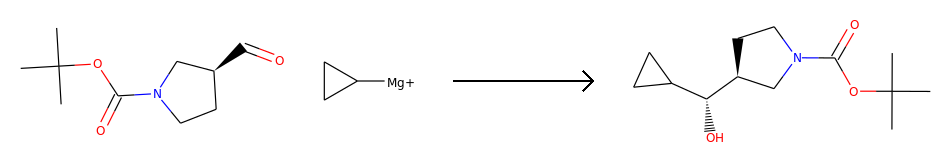

-> template: ([CH2;+0:1]-[CH;@;+0:2](-[CH2;+0:3])-[CH;@@;+0:4](-[CH;+0:5])-[OH;+0:6])>>[CH2;+0:1]-[CH;@;+0:4](-[CH2;+0:3])-[CH;+0:2]=[O;H0;+0:6].[CH;+0:5]-[Mg+]
No precursors could be generated!


--------------------------------------------------

RANK 59 PRECEDENT
PRODUCT MATCH SCORE: 0.492957746479


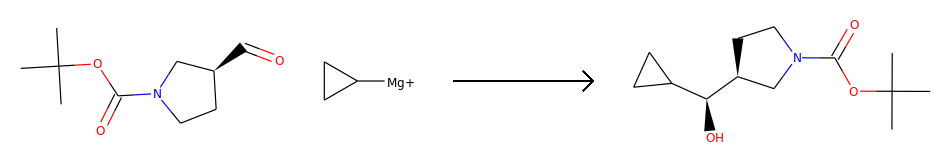

-> template: ([CH;+0:1]-[CH;@@;+0:2]-[OH;+0:3])>>[CH;+0:1]-[Mg+].[CH;+0:2]=[O;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 60 PRECEDENT
PRODUCT MATCH SCORE: 0.490384615385


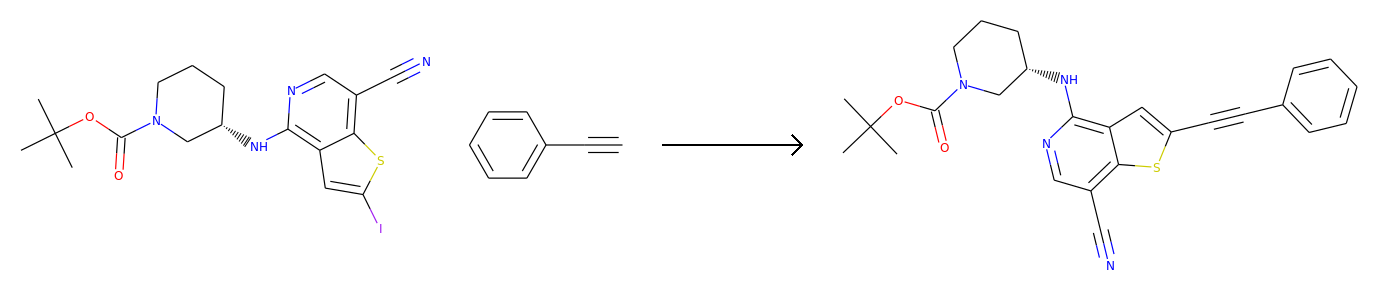

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.453703703704, overall 0.222489316239, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


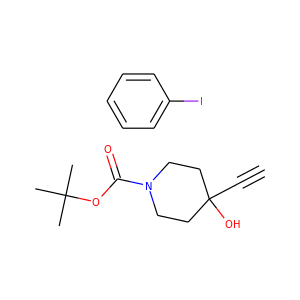



--------------------------------------------------

RANK 61 PRECEDENT
PRODUCT MATCH SCORE: 0.488888888889


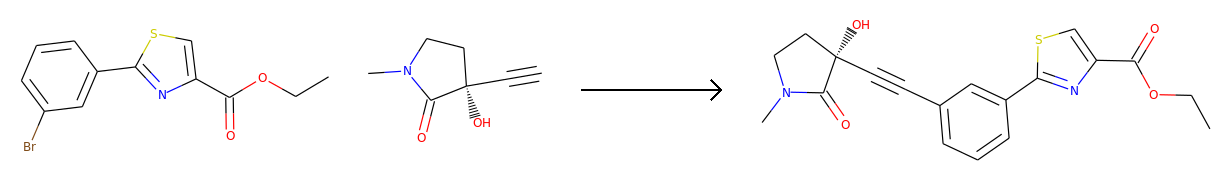

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.494505494505, overall 0.241758241758, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


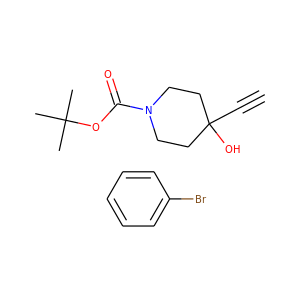



--------------------------------------------------

RANK 62 PRECEDENT
PRODUCT MATCH SCORE: 0.487179487179


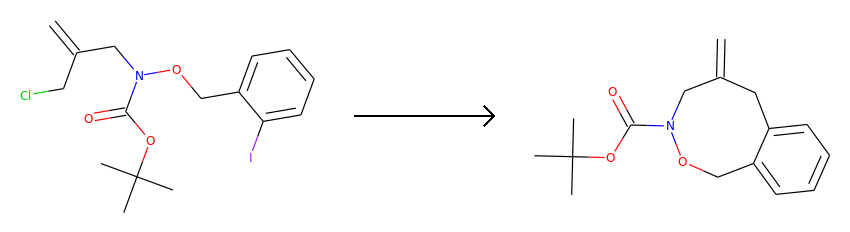

-> template: ([CH2;+0:1]-[c;H0;+0:2])>>Cl-[CH2;+0:1].I-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 63 PRECEDENT
PRODUCT MATCH SCORE: 0.486111111111


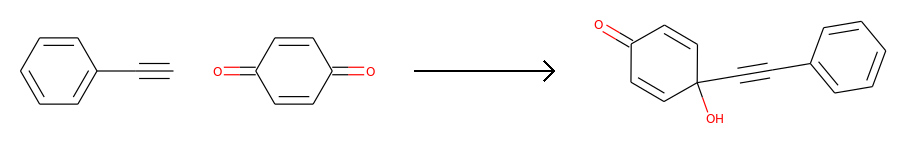

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH;+0:1]
Precursor similarity 0.478873239437, overall 0.232785602504, smiles C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(=O)CC1


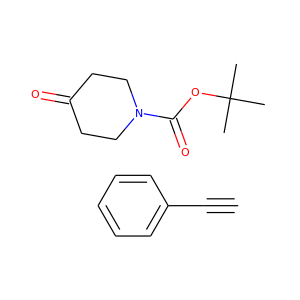



--------------------------------------------------

RANK 64 PRECEDENT
PRODUCT MATCH SCORE: 0.485714285714


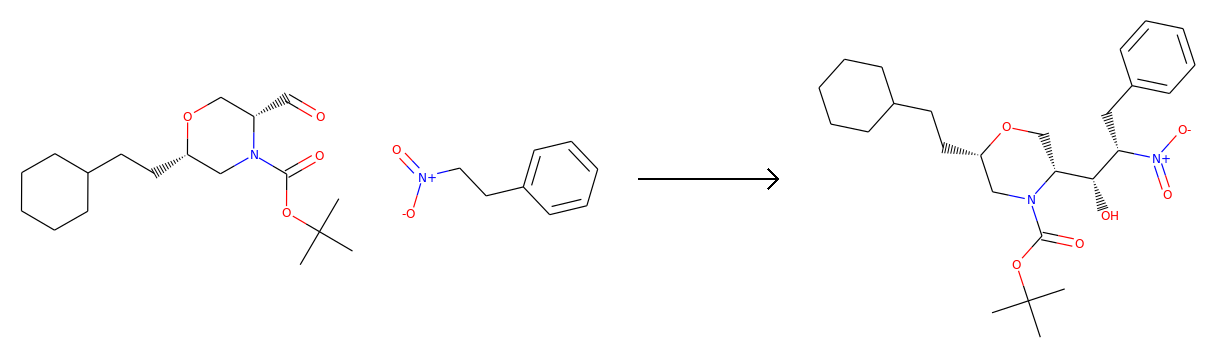

-> template: ([CH;@@;+0:1]-[CH;@@;+0:2]-[OH;+0:3])>>[CH2;+0:1].[CH;+0:2]=[O;H0;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 65 PRECEDENT
PRODUCT MATCH SCORE: 0.484848484848


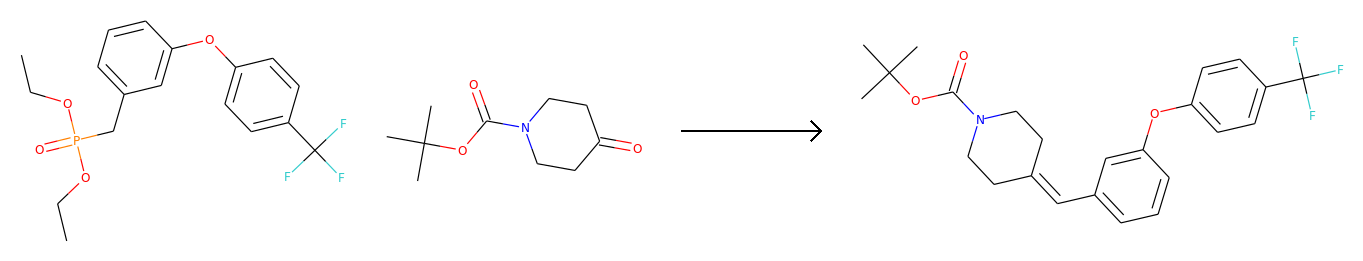

-> template: ([C;H0;+0:1]=[CH;+0:2])>>C-C-O-P(=O)(-[CH2;+0:2])-O-C-C.O=[C;H0;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 66 PRECEDENT
PRODUCT MATCH SCORE: 0.484210526316


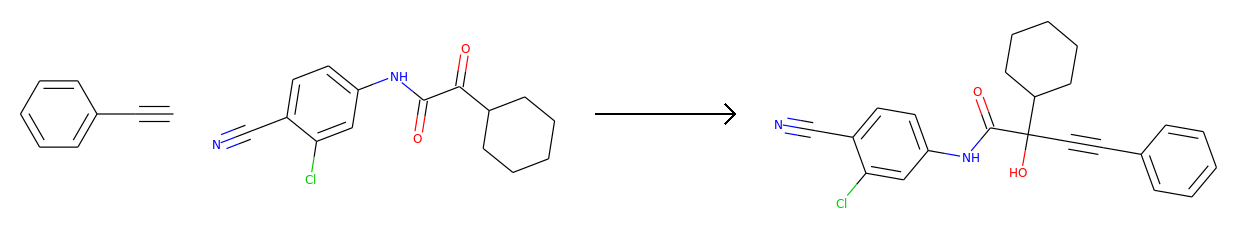

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH;+0:1]
Precursor similarity 0.478723404255, overall 0.231802911534, smiles C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(=O)CC1


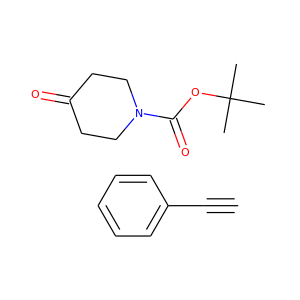



--------------------------------------------------

RANK 67 PRECEDENT
PRODUCT MATCH SCORE: 0.479591836735


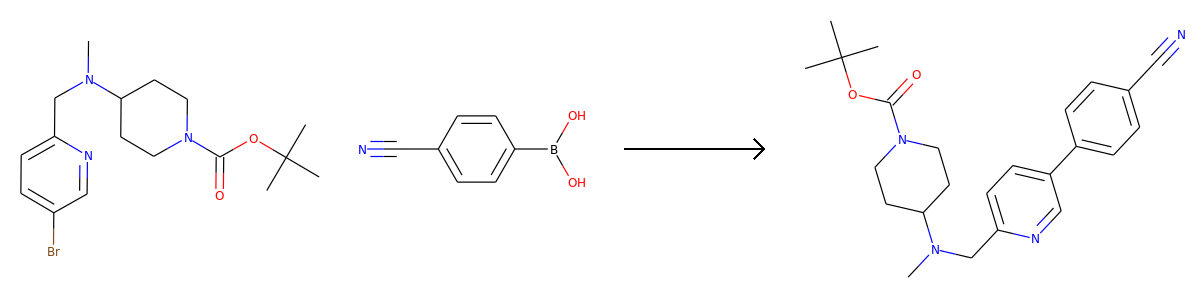

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 68 PRECEDENT
PRODUCT MATCH SCORE: 0.479166666667


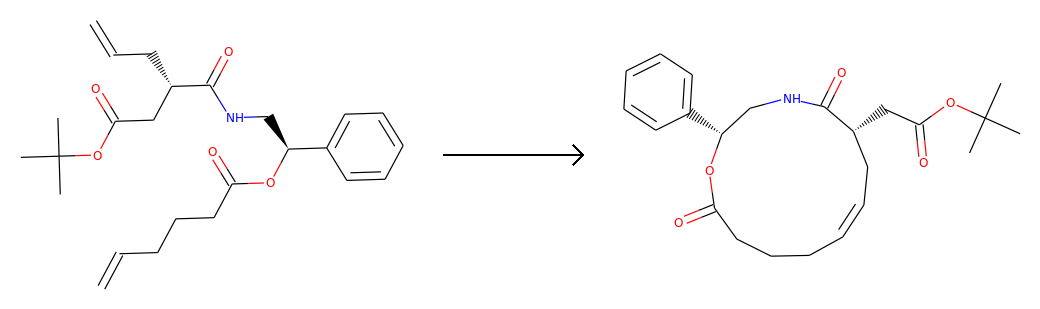

-> template: ([CH;+0:1]=[CH;+0:2])>>C=[CH;+0:1].C=[CH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 69 PRECEDENT
PRODUCT MATCH SCORE: 0.478873239437


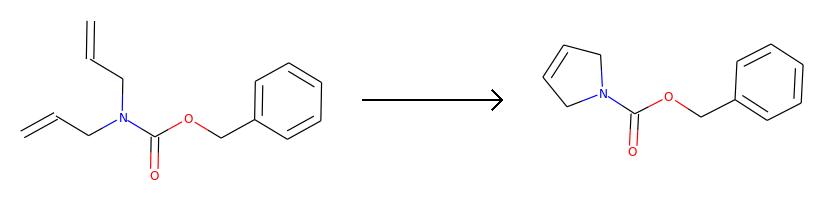

-> template: ([CH;+0:1]=[CH;+0:2])>>C=[CH;+0:1].C=[CH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 70 PRECEDENT
PRODUCT MATCH SCORE: 0.478260869565


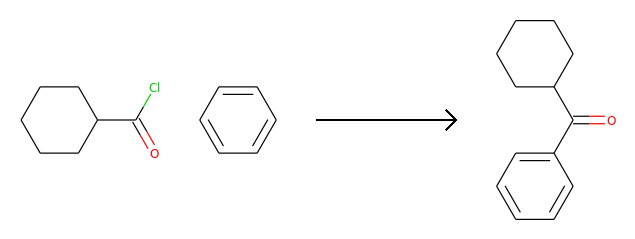

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Cl-[C;H0;+0:1].[cH;+0:2]
Precursor similarity 0.514285714286, overall 0.245962732919, smiles CC(C)(C)OC(=O)N1CCC(O)(C#CCl)CC1.c1ccccc1


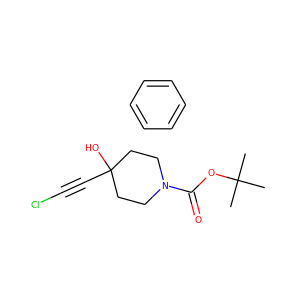



--------------------------------------------------

RANK 71 PRECEDENT
PRODUCT MATCH SCORE: 0.475609756098


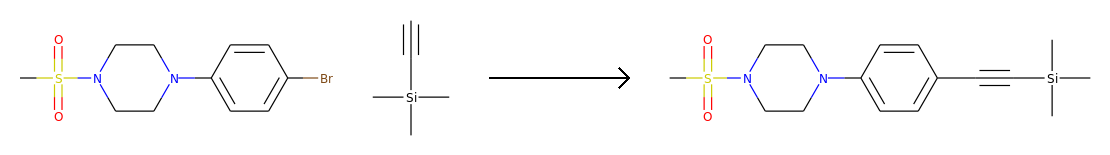

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.487804878049, overall 0.232004759072, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


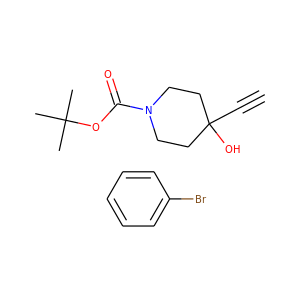



--------------------------------------------------

RANK 72 PRECEDENT
PRODUCT MATCH SCORE: 0.474358974359


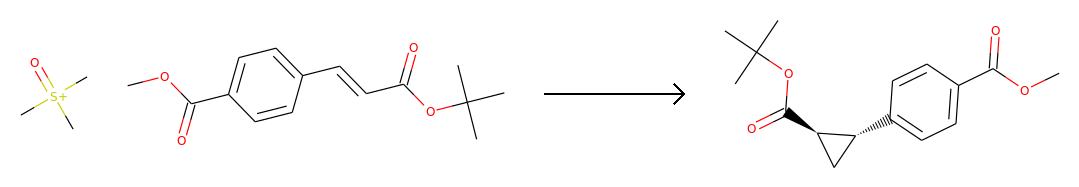

-> template: ([CH2;+0:1]1-[CH;@;+0:2]-[CH;@@;+0:3]-1)>>C-[S+](-C)(=O)-[CH3;+0:1].[CH;+0:3]=[CH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 73 PRECEDENT
PRODUCT MATCH SCORE: 0.474226804124


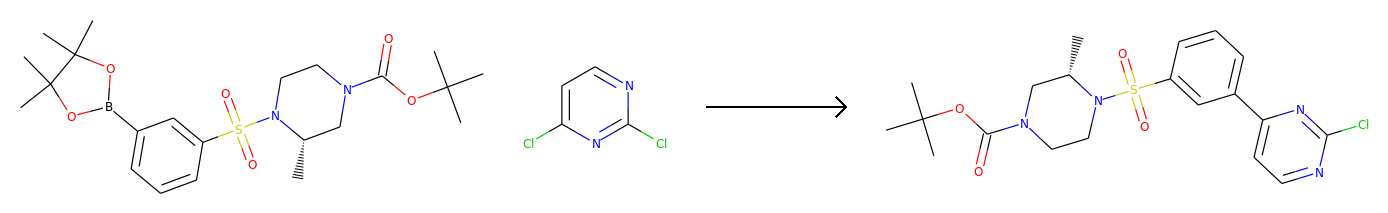

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>C-C1(-C)-O-B(-[c;H0;+0:1])-O-C-1(-C)-C.Cl-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 74 PRECEDENT
PRODUCT MATCH SCORE: 0.472527472527


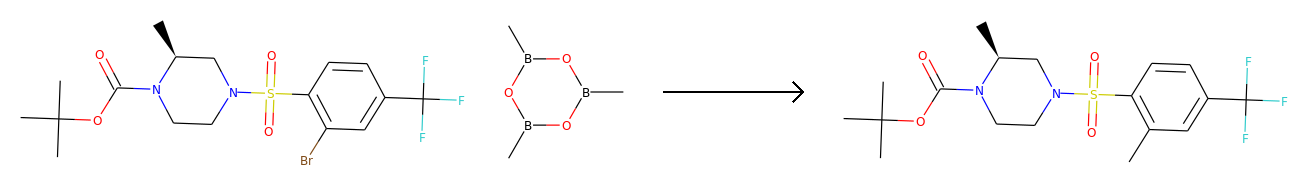

-> template: ([CH3;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-B1-O-B(-C)-O-B(-[CH3;+0:1])-O-1
No precursors could be generated!


--------------------------------------------------

RANK 75 PRECEDENT
PRODUCT MATCH SCORE: 0.472222222222


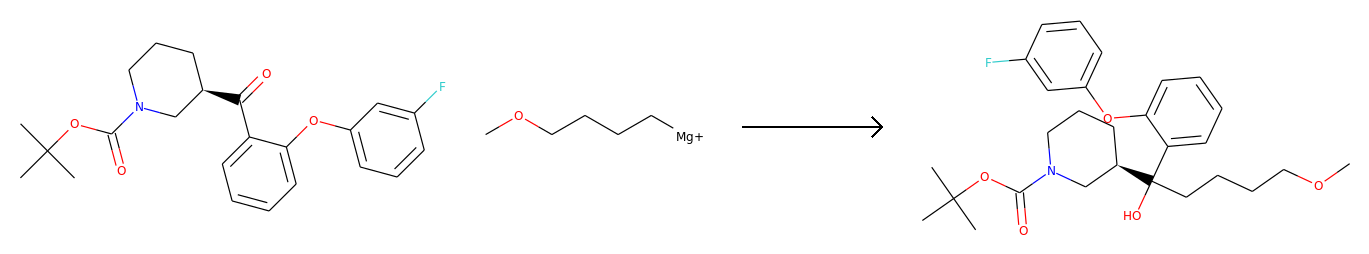

-> template: ([CH2;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH2;+0:1]-[Mg+]
Precursor similarity 0.495412844037, overall 0.233944954128, smiles CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1


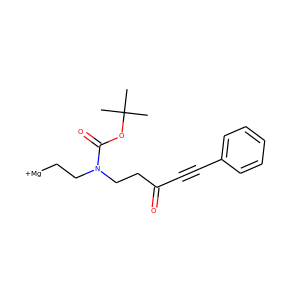



--------------------------------------------------

RANK 76 PRECEDENT
PRODUCT MATCH SCORE: 0.472222222222


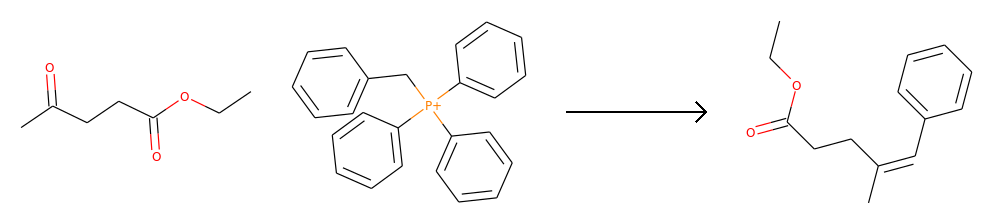

-> template: ([C;H0;+0:1]=[CH;+0:2])>>O=[C;H0;+0:1].[CH2;+0:2]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 77 PRECEDENT
PRODUCT MATCH SCORE: 0.47191011236


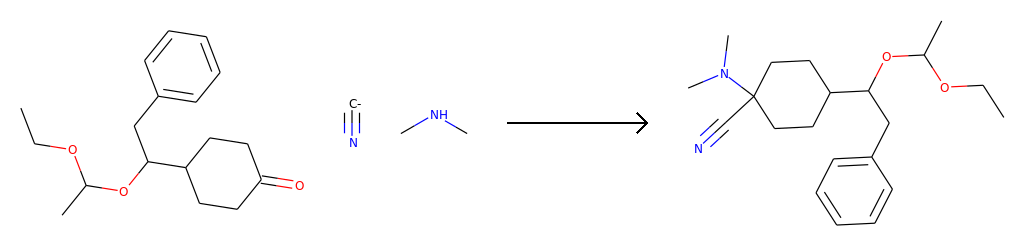

-> template: ([C;H0;+0:1]-[C;H0;+0:2]-[N;H0;+0:3])>>O=[C;H0;+0:2].[C-;H0:1].[NH;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 78 PRECEDENT
PRODUCT MATCH SCORE: 0.471428571429


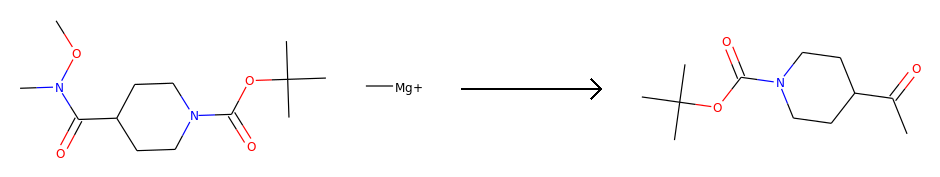

-> template: ([C;H0;+0:1]-[CH3;+0:2])>>C-O-N(-C)-[C;H0;+0:1].[CH3;+0:2]-[Mg+]
Precursor similarity 0.404494382022, overall 0.190690208668, smiles CON(C)C(C)(C)OC(=O)N1CCC(O)(C#Cc2ccccc2)CC1.C[Mg+]


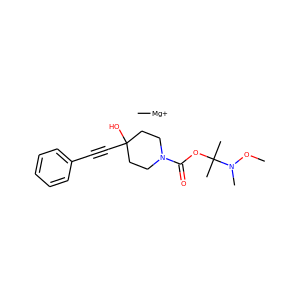



--------------------------------------------------

RANK 79 PRECEDENT
PRODUCT MATCH SCORE: 0.471264367816


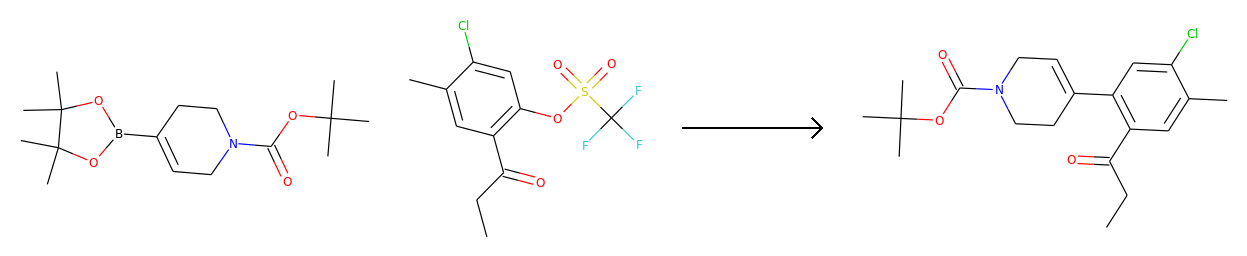

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>C-C1(-C)-O-B(-[C;H0;+0:1])-O-C-1(-C)-C.F-C(-F)(-F)-S(=O)(=O)-O-[c;H0;+0:2]
Precursor similarity 0.630769230769, overall 0.297259062776, smiles CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1.O=S(=O)(Oc1ccccc1)C(F)(F)F


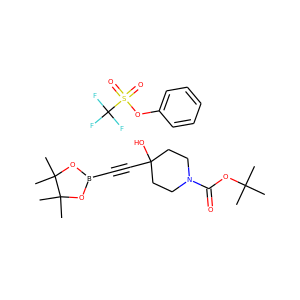



--------------------------------------------------

RANK 80 PRECEDENT
PRODUCT MATCH SCORE: 0.470588235294


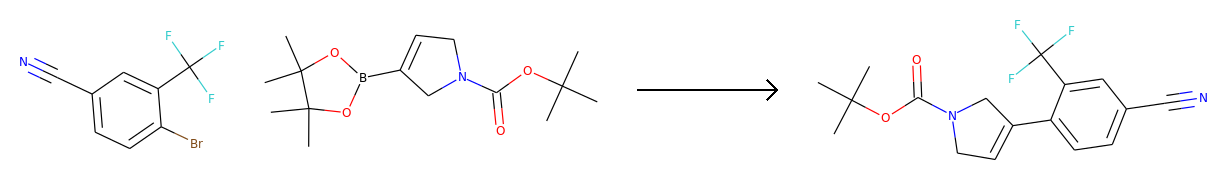

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].C-C1(-C)-O-B(-[C;H0;+0:1])-O-C-1(-C)-C
Precursor similarity 0.5625, overall 0.264705882353, smiles Brc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1


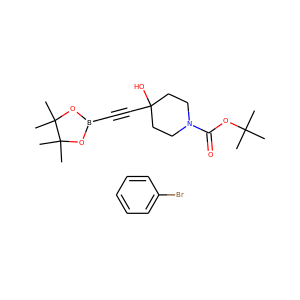



--------------------------------------------------

RANK 81 PRECEDENT
PRODUCT MATCH SCORE: 0.47


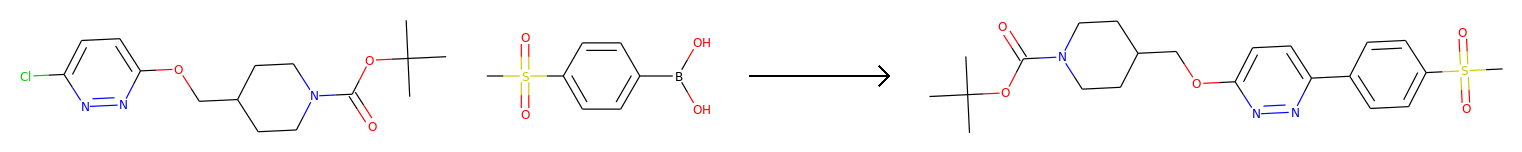

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 82 PRECEDENT
PRODUCT MATCH SCORE: 0.469879518072


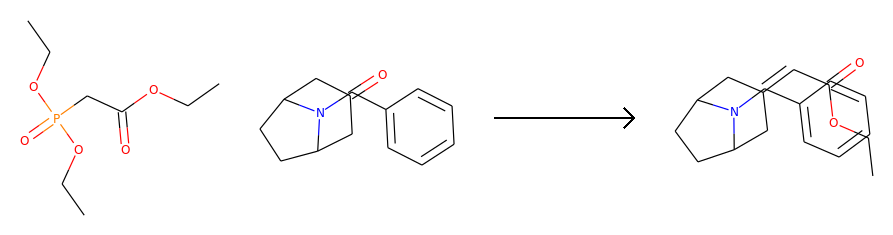

-> template: ([C;H0;+0:1]=[CH;+0:2])>>C-C-O-P(=O)(-[CH2;+0:2])-O-C-C.O=[C;H0;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 83 PRECEDENT
PRODUCT MATCH SCORE: 0.469387755102


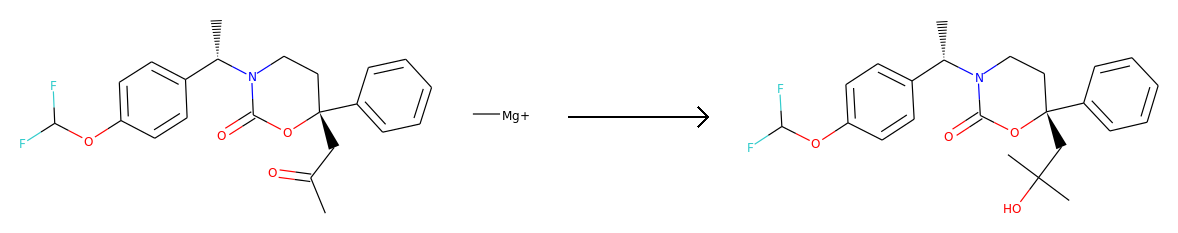

-> template: ([CH3;+0:1]-[C;H0;+0:2]-[OH;+0:3])>>[C;H0;+0:2]=[O;H0;+0:3].[CH3;+0:1]-[Mg+]
No precursors could be generated!


--------------------------------------------------

RANK 84 PRECEDENT
PRODUCT MATCH SCORE: 0.469135802469


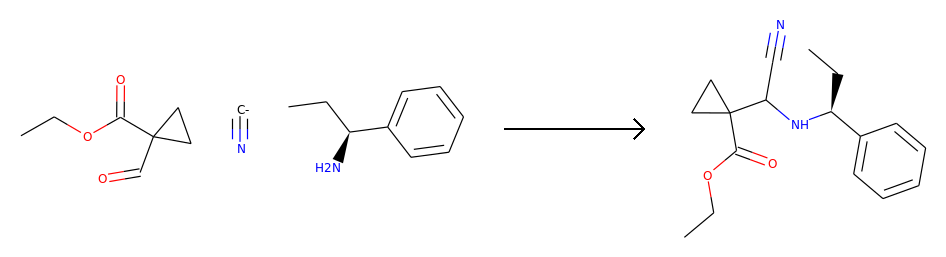

-> template: ([C;H0;+0:1]-[CH;+0:2]-[NH;+0:3])>>O=[CH;+0:2].[C-;H0:1].[NH2;+0:3]
No precursors could be generated!


--------------------------------------------------

RANK 85 PRECEDENT
PRODUCT MATCH SCORE: 0.46835443038


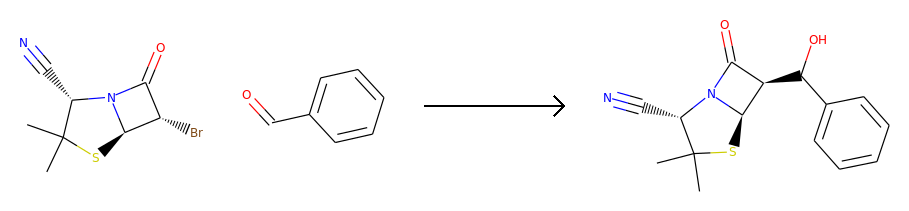

-> template: ([*:1]-[CH;@@;+0:2](-[*:3])-[CH;+0:4]-[OH;+0:5])>>Br-[CH;@;+0:2](-[*:1])-[*:3].[CH;+0:4]=[O;H0;+0:5]
No precursors could be generated!


--------------------------------------------------

RANK 86 PRECEDENT
PRODUCT MATCH SCORE: 0.46835443038


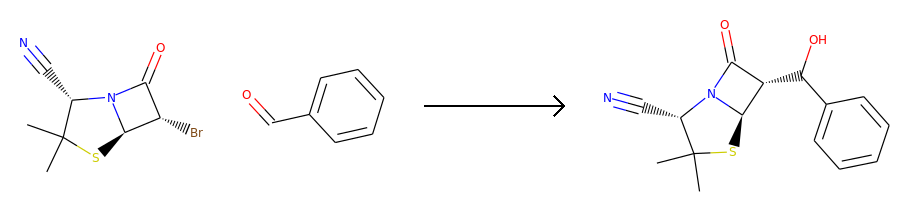

-> template: ([*:1]-[CH;@;+0:2](-[*:3])-[CH;+0:4]-[OH;+0:5])>>Br-[CH;@;+0:2](-[*:1])-[*:3].[CH;+0:4]=[O;H0;+0:5]
No precursors could be generated!


--------------------------------------------------

RANK 87 PRECEDENT
PRODUCT MATCH SCORE: 0.467532467532


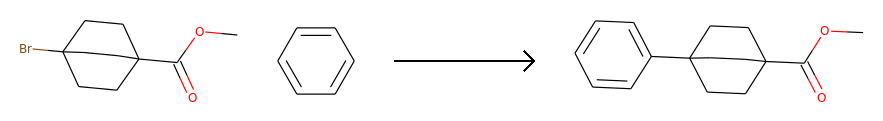

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[C;H0;+0:1].[cH;+0:2]
Precursor similarity 0.5, overall 0.233766233766, smiles CC(C)(C)OC(=O)N1CCC(O)(C#CBr)CC1.c1ccccc1


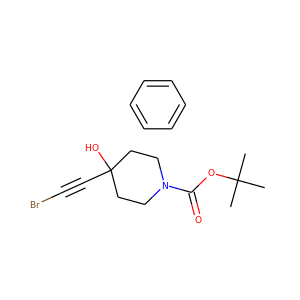



--------------------------------------------------

RANK 88 PRECEDENT
PRODUCT MATCH SCORE: 0.466666666667


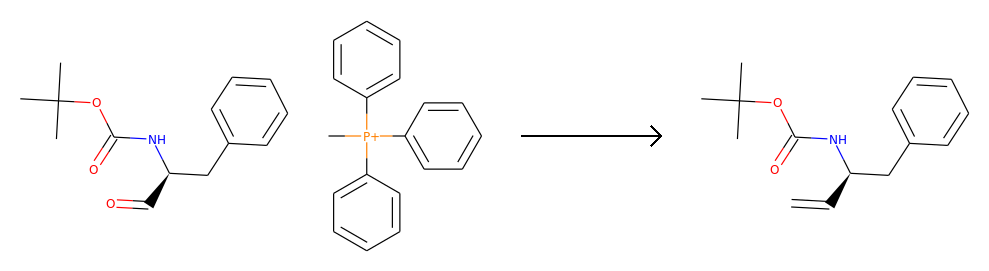

-> template: ([CH2;+0:1]=[CH;+0:2])>>O=[CH;+0:2].[CH3;+0:1]-[P+](-c1:c:c:c:c:c:1)(-c1:c:c:c:c:c:1)-c1:c:c:c:c:c:1
No precursors could be generated!


--------------------------------------------------

RANK 89 PRECEDENT
PRODUCT MATCH SCORE: 0.465909090909


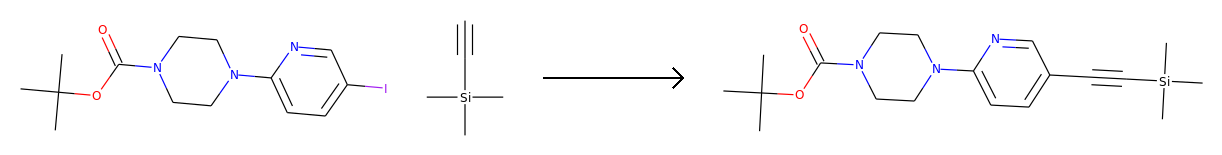

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.477272727273, overall 0.222365702479, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


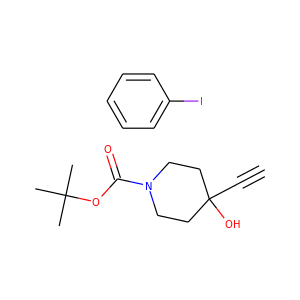



--------------------------------------------------

RANK 90 PRECEDENT
PRODUCT MATCH SCORE: 0.464285714286


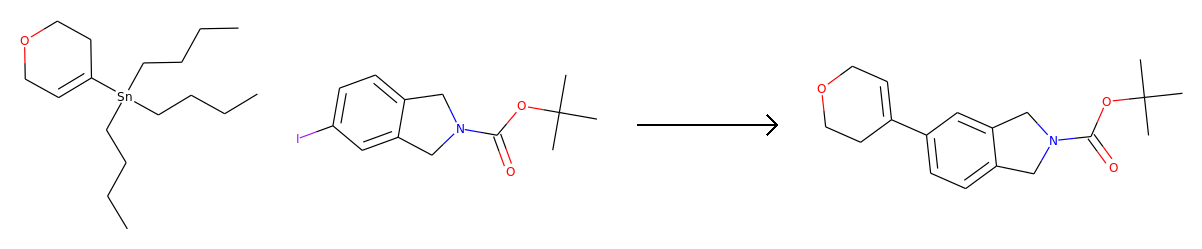

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>C-C-C-C-[Sn](-[C;H0;+0:1])(-C-C-C-C)-C-C-C-C.I-[c;H0;+0:2]
Precursor similarity 0.617886178862, overall 0.2868757259, smiles CCCC[Sn](C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1)(CCCC)CCCC.Ic1ccccc1


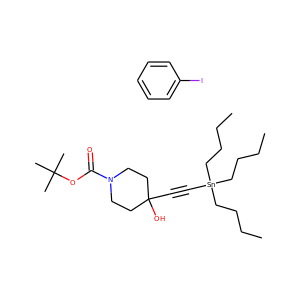



--------------------------------------------------

RANK 91 PRECEDENT
PRODUCT MATCH SCORE: 0.464285714286


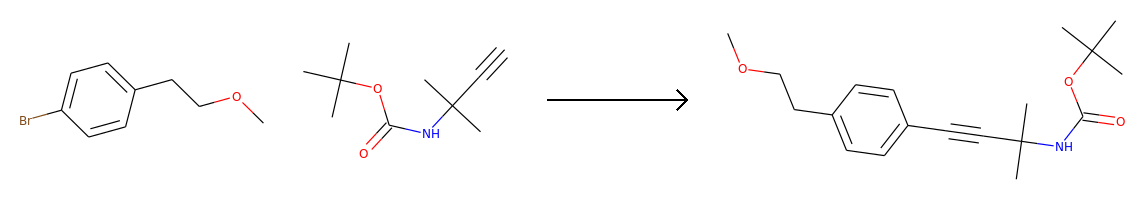

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.470588235294, overall 0.218487394958, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


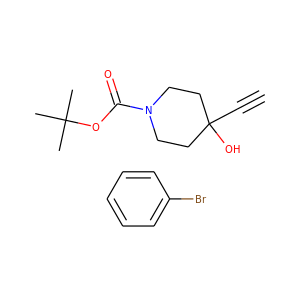



--------------------------------------------------

RANK 92 PRECEDENT
PRODUCT MATCH SCORE: 0.463157894737


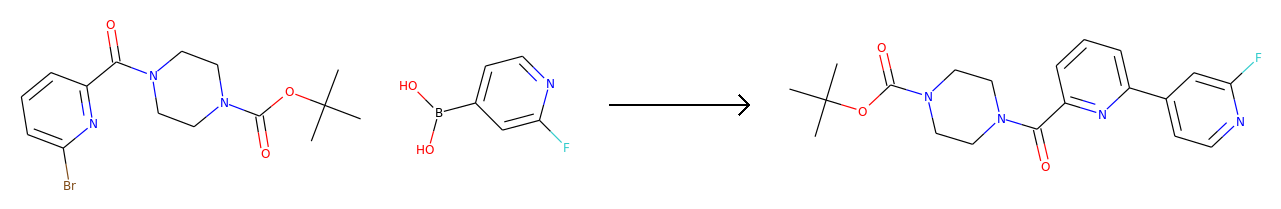

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 93 PRECEDENT
PRODUCT MATCH SCORE: 0.463157894737


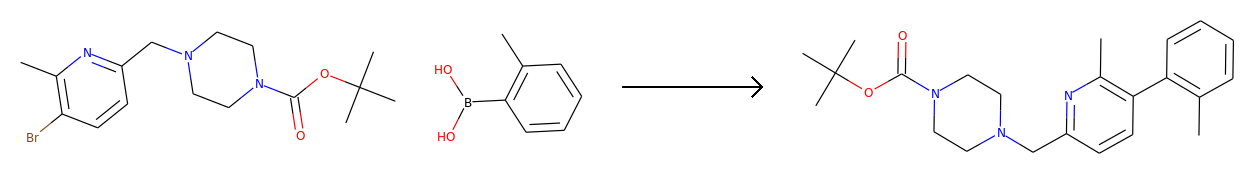

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 94 PRECEDENT
PRODUCT MATCH SCORE: 0.463157894737


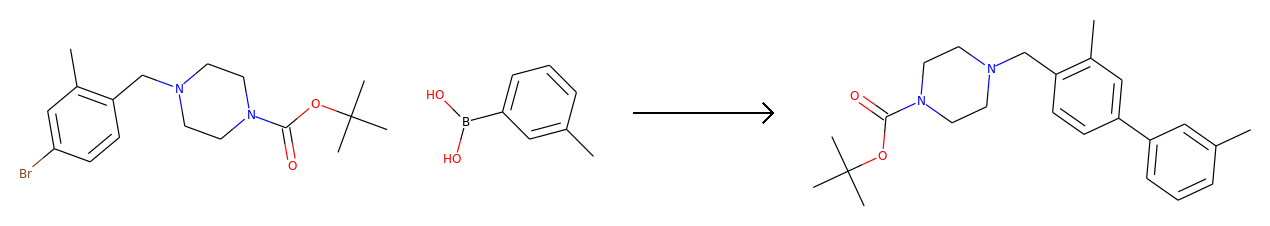

-> template: ([c;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:1].O-B(-O)-[c;H0;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 95 PRECEDENT
PRODUCT MATCH SCORE: 0.462365591398


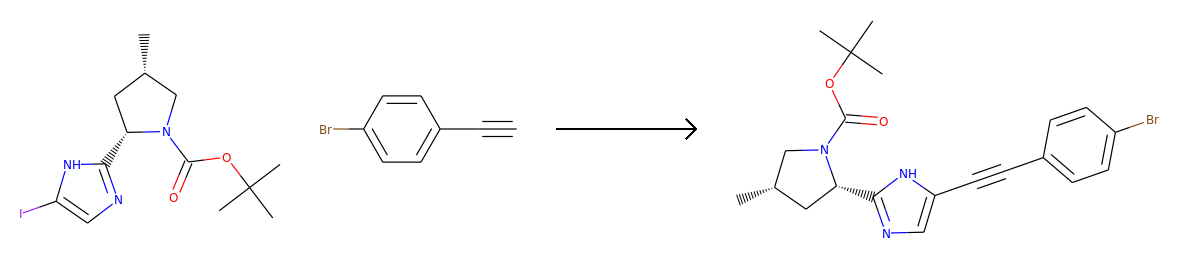

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.483870967742, overall 0.22372528616, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


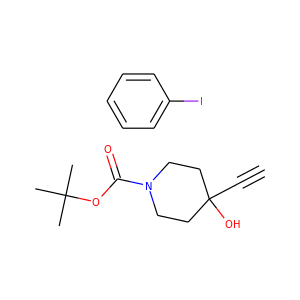



--------------------------------------------------

RANK 96 PRECEDENT
PRODUCT MATCH SCORE: 0.460674157303


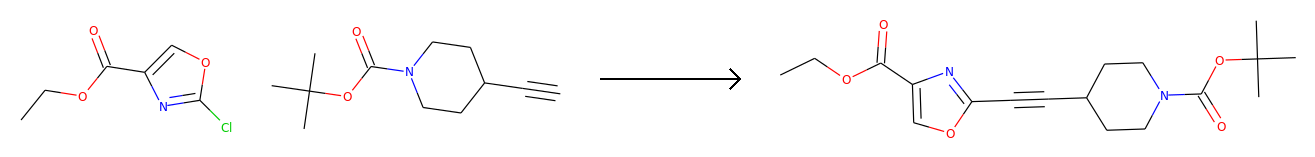

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Cl-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.483146067416, overall 0.222572907461, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Clc1ccccc1


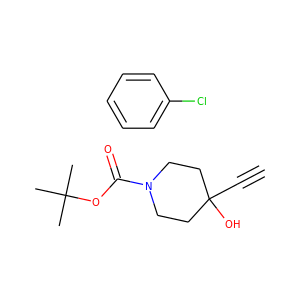



--------------------------------------------------

RANK 97 PRECEDENT
PRODUCT MATCH SCORE: 0.458823529412


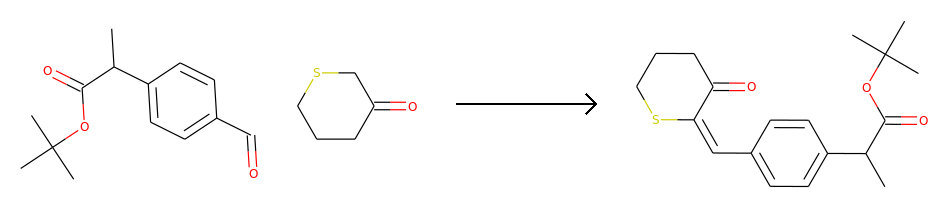

-> template: ([C;H0;+0:1]=[CH;+0:2])>>O=[CH;+0:2].[CH2;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 98 PRECEDENT
PRODUCT MATCH SCORE: 0.456896551724


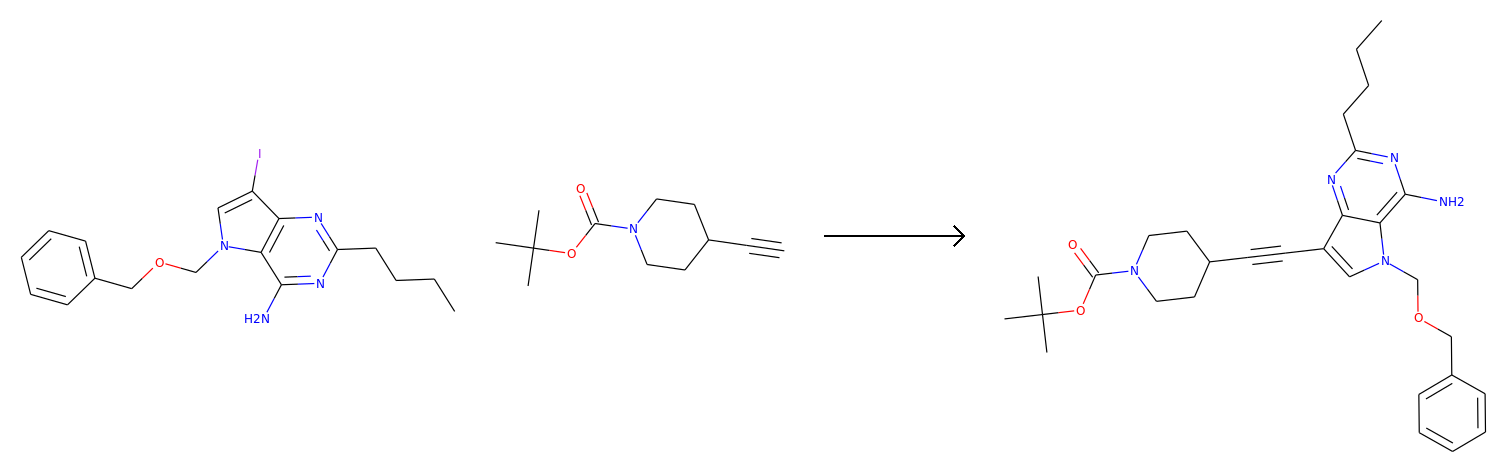

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.436974789916, overall 0.199652274703, smiles C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1.Ic1ccccc1


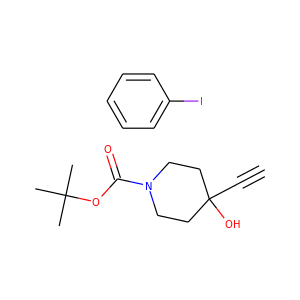



--------------------------------------------------

RANK 99 PRECEDENT
PRODUCT MATCH SCORE: 0.45652173913


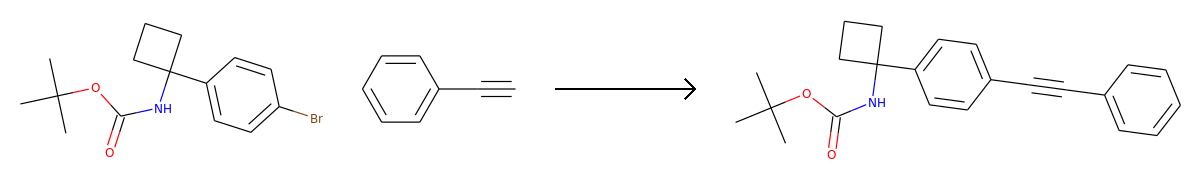

-> template: ([C;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[CH;+0:1]
Precursor similarity 0.478260869565, overall 0.218336483932, smiles Brc1ccccc1.C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


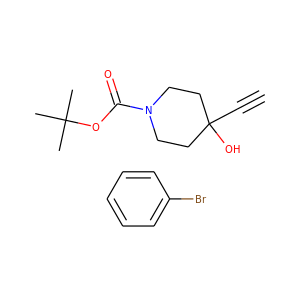



--------------------------------------------------

RANK 100 PRECEDENT
PRODUCT MATCH SCORE: 0.455882352941


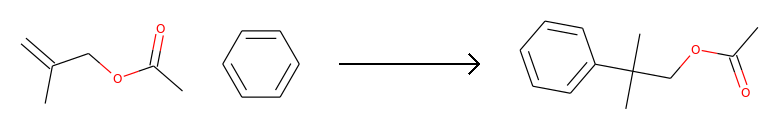

-> template: ([CH3;+0:1]-[C;H0;+0:2]-[c;H0;+0:3])>>[C;H0;+0:2]=[CH2;+0:1].[cH;+0:3]
No precursors could be generated!


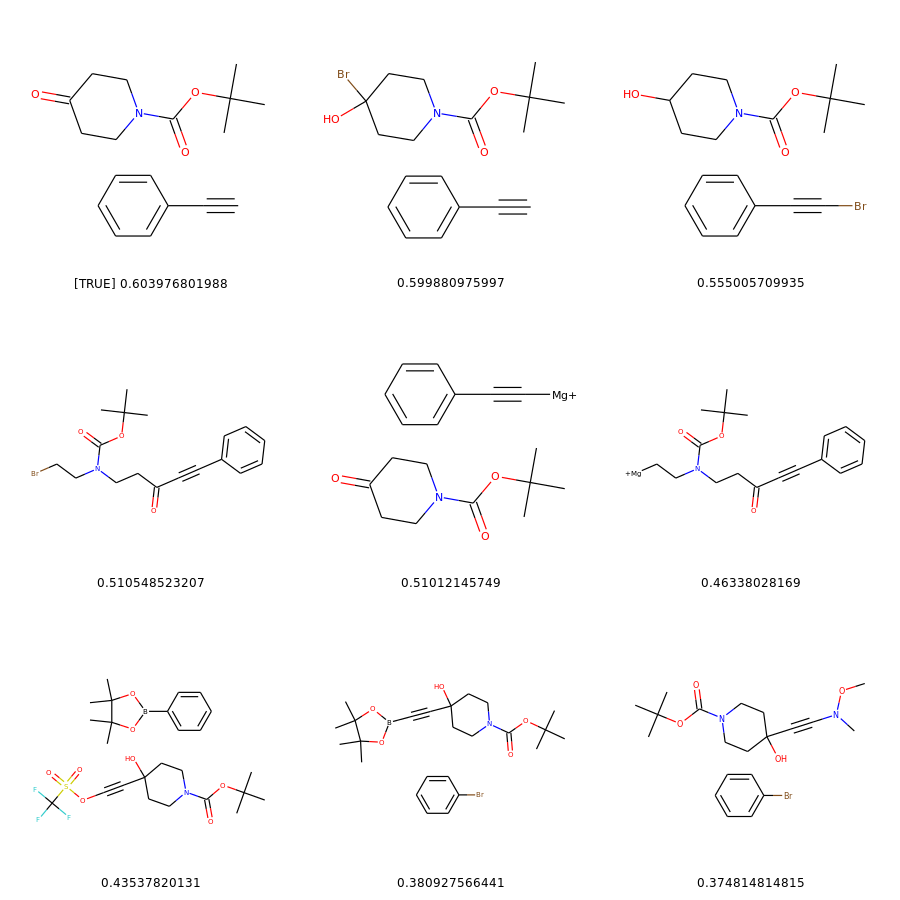

C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(=O)CC1
C#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(Br)CC1
BrC#Cc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)CC1
CC(C)(C)OC(=O)N(CCBr)CCC(=O)C#Cc1ccccc1
CC(C)(C)OC(=O)N1CCC(=O)CC1.[Mg+]C#Cc1ccccc1
CC(C)(C)OC(=O)N(CC[Mg+])CCC(=O)C#Cc1ccccc1
CC(C)(C)OC(=O)N1CCC(O)(C#COS(=O)(=O)C(F)(F)F)CC1.CC1(C)OB(c2ccccc2)OC1(C)C
Brc1ccccc1.CC(C)(C)OC(=O)N1CCC(O)(C#CB2OC(C)(C)C(C)(C)O2)CC1
Brc1ccccc1.CON(C)C#CC1(O)CCN(C(=O)OC(C)(C)C)CC1


1

In [13]:
import random
if class_ != 'all': 
    random.seed(123)
else:
    import time
    random.seed(time.time())
ix = [ixi for ixi in datasub_val.loc[datasub_val['class'] == 3].index]
ixi = random.choice(ix)
print(ixi)
print(class_)
ixi = 45105
do_one(ixi, debug=False, draw=True, nopause=True)